<img src="https://www.preferendum.fr/hubfs/lead-scoring.jpg" width="800">

# Credit Scoring Model

* Гиль Юлия
* Группа DSPR-28

# Table of Contents

1. [IMPORT & FUNCTIONS](#1)
2. [DDATA & PRELIMINARY ANALYSIS](#2)
4. [EDA](#3)
    * [NAN Processing ](#3.1)
    * [Features Analysis ](#3.2)
    * [Target Analysis](#3.3)
4. [NAÏVE MODEL](#4)
6. [MODEL IMPROVEMENTS](#5)
    * [Model with Feature Engineering, IQR Analysis](#5.1)
    * [Model with Feature Selection: Сorrelation, RFE](#5.2)
    * [Model OVER- UNDER-Sampling](#5.3)
    * [Model Hyperparameters Tuning](#5.4)
    * [Experiments Summary](#5.5)
7. [SUBMISSION](#7)
8. [SUMMARY](#8)

<a id="1"></a>
# 1. IMPORT & FUNCTIONS

<a id="1.1"></a>
## 1.1 Import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

#import sys
#!{sys.executable} -m pip install -U pandas-profiling[notebook]
#!jupyter nbextension enable --py widgetsnbextension
# pip install -U imbalanced-learn

import os
import warnings
import imblearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import ttest_ind
from itertools import combinations
from pandas_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif, RFE
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, classification_report
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline
warnings.simplefilter('ignore')
sns.set()

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

<a id="1.2"></a>
## 1.2 FUNCTIONS

Добавим пользовательские функции.

In [4]:
def hot_enc(df, column):
    """
    Функция на вход принимает:
        - датафрейм
        - колонку, для которой необходимо применить OneHotEncoding.

    One Hot Encoding подразумевает создание N (количество категорий) новых признаков, все из которых равны нулю, за исключением одного.
    На позицию, соответствующую численному значению признака, мы помещается 1.

    На выход получаем датафрейс с созданными колонками для перекодированного признака.
        - Новые колонки будут называться 'hot_имя_колонки_номер'
    """
    ohe = OneHotEncoder(sparse=False)
    df_one = pd.DataFrame(ohe.fit_transform(df[[column]]))
    df_one.columns = ohe.get_feature_names([f'hot_{column}'])
    df = df.drop(column, axis=1)  # удаляем колонку, которую кодировали
    df = pd.concat([df, df_one], axis=1)  # добавляем перекодированные колонки
    return df


def preproc_data(df_input, drop_list=False):
    '''
    Включены операции по предобработке данных для модели: копирование, удаление некоторых колонок (скореллированных, нечисловых).

    Вход:
        - датафрейм
        - drop_list:
            - пустое значение, = False по умолчанию, т.е. оставляем набор колонок как в изначальном датасете
            - = True, тогда удаляем из датачета мультиколинеарные признаки, которые получили через корелляционный анализ.

    Выход: итоговой датафрейм.
    '''

    df_output = df_input.copy()

    if drop_list == True:
        # удаляем признаки, которые сильно скореллированы с др. признаками
        df_output.drop(correlated_features, axis=1, inplace=True)

    # Модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [
        s for s in df_output.columns if df_output[s].dtypes in ['object', '<M8[ns]']]
    df_output.drop(object_columns, axis=1, inplace=True)

    return df_output


def data_preparing(df, cols_update=False, prep_type='train'):
    """
    Подготовка данных к машинному обучению:
        - кодирование категориальных признаков
        - стандартизация числовых переменных
        - фича селекшен по RFE, если задан флаг
        - выделение test/train части из данных в соотвествии с флагом
        - формирование X, y для машинного обучения.

    Вход:
        - датафрейм
        - cols_update:
            - пустое значение, = False по умолчанию, т.е. оставляем набор колонок как в изначальном датасете
            - = True, тогда удаляем из датаcета признаки из списка cols_update
        - prep_type - задает, какой набор данных train или test использовать.

    Выход:
        - X - признаки для обучения
        - y - целевая переменная
        - cols - список с именами признаков X.
    """
    # Закодируем категориальные колонки, удалим их из датасета
    cols_to_encode = list(set(df.columns) & set(cat_cols))
    for col in cols_to_encode:
        df = hot_enc(df, col)

    # Стандартизация числовых переменных
    cols_to_scale = list(set(df.columns) & set(num_cols))
    df[cols_to_scale] = StandardScaler().fit_transform(df[cols_to_scale].values)

    # Удаляем доп признаки, если задан флаг
    if cols_update == True:
        # Удаляем список cols_update
        result = list(set(final_cols + ['default', 'sample']))
        df = df[result]

    # Теперь выделим тестовую и тренировочную части
    if prep_type == 'train':
        df = df.query('sample == 1').drop(
            ['sample'], axis=1).reset_index(drop=True)
    if prep_type == 'test':
        df = df.query('sample == 0').drop(
            ['sample'], axis=1).reset_index(drop=True)

    # Сформируем X, y, список колонок, которые были использованы для признаков X
    # в X не должно быть index, default, client_id
    add_drop = list(set(df.columns) & set(['default', 'client_id', 'index']))
    X = df.drop(add_drop, axis=1).values
    y = df[['default']].values
    # список признаков, из которых формировался X
    cols = df.drop(add_drop, axis=1).columns

    return X, y, cols


def log_model_use(model, X_train, X_test, y_train, y_test):
    """
    Обучение модели логистической регрессии на разбитой выборке.

    Вход:
        - модель
        - данные X_train, X_test, y_train, y_test

    Выход:
        - y_pred - предсказание значения дефолта для X_test
        - probs - предсказание значения вероятности дефолта заемщика для X_test
    """
    # Обучаем модель на тестовом наборе данных
    model.fit(X_train, y_train)

    # Используем обученную модель для предсказания дефолта в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = model.predict(X_test)

    # Предсказанные значения вероятностей записываем в переменную probs
    probs = model.predict_proba(X_test)[:, 1]
    return y_pred, probs


def make_confusion_matrix(cf,
                          group_names=['TN', 'FP', 'FN', 'TP'],
                          categories='auto',
                          sum_stats=True,
                          count=True,
                          cbar=True,
                          percent=True,
                          cmap='BuPu'):
    '''
    Функция для построения графика матрицы ошибок.

    Вход:
        - cf - вычесленная матрица ошибок
        - group_names - имена всех групп
        - categories - категории, которые отображаются на осях x, y. По умолчанию 'auto'
        - sum_stats - показывает метрики, по умолчанию TRUE
        - c_bar:
            - если True, показывает цветовой бар. Значения базируются на матрице ошибок confusion matrix
            - по умолчанию True
        - percent - отображение по x,y осям. По умолчанию, True
    '''
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    group_labels = ["{}\n".format(value) for value in group_names]

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = [
            "{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)
        ]
    else:
        group_percentages = blanks

    box_labels = [
        f"{v1}{v2}{v3}".strip()
        for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # Metrics
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))
        ball_accuracy = .5 * (cf[1, 1] / sum(cf[1, :]) +
                              cf[0, 0] / sum(cf[0, :]))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # pr = how many real true
            precision = cf[1, 1] / sum(cf[:, 1])
            # How many positives from all positives
            recall = cf[1, 1] / sum(cf[1, :])
            # F1 score
            f1 = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nBallancedAcc={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, ball_accuracy, precision, recall, f1)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    plt.rcParams.get('figure.figsize')
    plt.figure()

    sns.heatmap(cf,
                annot=box_labels,
                fmt="",
                cmap=plt.cm.Blues,
                cbar=cbar,
                xticklabels=categories,
                yticklabels=categories)
    plt.ylabel('Expected')
    plt.xlabel('Predicted' + stats_text)
    plt.show()


def cross_validation(model, X_train, X_test, y_train, y_test):
    """
    Кросс-валидация работы модели логистической регрессии на разбитой выборке.
    Функция отрисовывает значения F1-Score метрики для X_train и X_test на 30 фолдах.

    Вход:
        - модель
        - данные X_train, X_test, y_train, y_test

    """
    # Посчитаем метрику F1 для 30 фолдов.
    train_score = cross_val_score(model, X_train, y_train, cv=30, scoring='f1')
    test_score = cross_val_score(model, X_test, y_test, cv=30, scoring='f1')

    # Посчитаем среднее и стандартное отклонение F1 для 30 фолдов для теста и для трейна
    avg_f1_train, std_f1_train = train_score.mean(), train_score.std()
    avg_f1_test, std_f1_test = test_score.mean(), test_score.std()

    # Отрисуем графики изменения метрики F1

    plt.figure(figsize=(15, 8))

    plt.plot(
        train_score, label=f'[Train] F1-score: {avg_f1_train:.2f} $\pm$ {std_f1_train:.2f}', marker='.')
    plt.plot(
        test_score, label=f'[Test] F1-score: {avg_f1_test:.2f} $\pm$ {std_f1_test:.2f}', marker='.')

    plt.ylim([0.2, 1.])
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)
    plt.show()


def generate_report(ml_report, roc_auc, accuracy, precision, recall, f1_score, f1_def, exp_name):
    '''
    Функция добавляет в финальный отчет машинного обучения результаты эксперимента (метрики).

    Вход:
        - отчет (датафрейм)
        - значения метрик для эксперимента
        - имя эксперимента

    Выход:
        - обновленный отчет
    '''
    # Создаем отчет для эксперимент, добавляем значения метрик
    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc
    report['F1-Score'] = f1_score
    report['F1-Score Default'] = f1_def
    report['Precision'] = precision
    report['Recall'] = recall
    report['Accuracy'] = accuracy
    report.index = [exp_name]

    # Добавляем отчет одного эксперимента в суммарный отчет
    ml_report = ml_report.append(report)

    return ml_report


def model_metrics(y_test, y_pred, probs):
    '''
    Функция позволяет отобразить метрики и графики для эксперимента, 
    а также рассчитывает и возвращает основные метрики машинного обучения для эксперимента:
        - отчет с метриками accuracy, recall, f-1 (macro, average)
        - ROC-AUC график
        - матрица ошибок.

    Вход:
        - y_test - фактические значения дефолта заемщика
        - y_pred - предсказанные моделью значения дефолта заемщика
        - probs - предсказаныее моделью значения вероятности дефолта заемщика

    Выход:
        - графики
        - округленные значения основных метрик (roc_auc, accuracy, precision - macro, recall - macro, f1-score - macro)
    '''
    # Отображение отчета по метрикам точности, полноты, F-меры и поддержки
    print("\nМЕТРИКИ МОДЕЛИ \n\nОсновные метрики\n\n", classification_report(
        y_test, y_pred, target_names=['non-default (0)', 'default (1)']))

    # Подсчет основных метрик
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    # выбираем macro (и для 0, и для 1)
    precision = round(precision_score(y_test, y_pred, average='macro'), 3)
    recall = round(recall_score(y_test, y_pred, average='macro'), 3)
    f1_macro = round(f1_score(y_test, y_pred, average='macro'), 3)
    f1_def = round(f1_score(y_test, y_pred), 3)

    # Построим ROC график
    print("\n\nROC-кривая\n")

    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    # Матрица ошибок
    print("\n\nМатрица ошибок\n")
    cf = confusion_matrix(y_test, y_pred)
    categories = ['Non-Default', 'Default']
    make_confusion_matrix(confusion_matrix(y_test, y_pred),
                          categories=categories, sum_stats=False)

    return round(roc_auc, 3), accuracy, precision, recall, f1_macro, f1_def


def iqr_analysis(series, mode=False):
    """
    Функция выводит инфорамцию о границах выборосов для признака.
    Если mode = True, возвращается верхняя и нижняя границы выбросов. Иначе, просто выводится информация на экран.
    """
    IQR = series.quantile(0.75) - series.quantile(0.25)
    perc25 = series.quantile(0.25)
    perc75 = series.quantile(0.75)

    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR

    if mode:
        return f, l

    print(
        "\n25-й перцентиль: {},".format(perc25),
        "\n75-й перцентиль: {},".format(perc75),
        "\nIQR: {}, ".format(IQR),
        "\nГраницы выбросов: [{f}, {l}].".format(
            f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR),
        "\n\nМинимальное значение признака: {}.".format(series.min()),
        "\nМаксимальное значение признака: {} .\n".format(series.max()))

    if series.min() < f:
        print("Найдены выбросы по нижней границе признака! Количество: {}, {}%".format(series.where(
            series < f).count(), round(series.where(series < f).count()/series.count()*100, 2)))
    if series.max() > l:
        print("Найдены выбросы по верхней границе признака! Количество: {}, {}%".format(series.where(
            series > l).count(), round(series.where(series > l).count()/series.count()*100, 2)))


def get_stat_dif(column):
    """ 
    Поиск статистически значимых различий для колонки с помощью теста Стьюдента.
    """
    cols = data.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))

    tmp = data[data['sample'] == 1]

    for comb in combinations_all:
        if ttest_ind(tmp.loc[data[data['sample'] == 1].loc[:, column] == comb[0], 'default'],
                     tmp.loc[data[data['sample'] == 1].loc[:, column] == comb[1], 'default']).pvalue <= 0.05/len(combinations_all):  # учли поправку Бонферони
            # print('Найдены статистически значимые различия для колонки и комбинаций', column, comb)
            pass
        else:
            print(
                'Не найдены статистически значимые различия для колонки и комбинации', column, comb)
            return column
            break


def resemble_result(X, y, flag='SMOTE', report=True):
    """
    Функция позволяет сделать over/under-sampling для несбалансированных данных.

    Вход:
        - X, y - данные для машинного обучения
        - flag - тип семплирования (может быть SMOTE, ADASYN,RandomOverSampler, RandomUnderSampler), по умолчанию, SMOTE over-sampling
        - report - флаг, который показывает, требуется ли выводить на экран информацию о проводенном семплировании. По умолчанию True.

    Выход:
        - X_resampled, y_resampled - семплированные данные для машинного обучения
    """
    if flag == 'SMOTE':
        # Over-Sampling при помощи SMOTE
        os = SMOTE(random_state=RANDOM_SEED)
        X_resampled, y_resampled = os.fit_resample(X, y)

    if flag == 'ADASYN':
        # Over-Sampling при помощи ADASYN
        ad = ADASYN(random_state=RANDOM_SEED)
        X_resampled, y_resampled = ad.fit_resample(X, y)

    if flag == 'RandomOverSampler':
        # Over-Sampling при помощи RandomOverSampler
        ros = RandomOverSampler(random_state=RANDOM_SEED)
        X_resampled, y_resampled = ros.fit_resample(X, y)

    if flag == 'RandomUnderSampler':
        # Under-Sampling при помощи RandomUnderSampler
        rus = RandomUnderSampler(random_state=RANDOM_SEED)
        X_resampled, y_resampled = rus.fit_resample(X, y)

    # Выводим отчет о семплировании, если флаг report == True
    if report == True:
        # Создаем датафрейм для удобства визуализации
        y_resampled_df = pd.DataFrame(y_resampled, columns=['default'])

        # Проверяем, какие данные получились после семплирования
        print("Количество дефолтных клиентов в новом датасете:",
              len(y_resampled_df[y_resampled_df['default'] == 1]))
        print("Количество недефолтных клиентов в новом датасете:",
              len(y_resampled_df[y_resampled_df['default'] == 0]))
        print("\nДоля дефолтных клиентов в новом датасете:", len(
            y_resampled_df[y_resampled_df['default'] == 1])/len(X_resampled))
        print("Доля недефолтных клиентов в новом датасете:", len(
            y_resampled_df[y_resampled_df['default'] == 0])/len(X_resampled))

        # Посмотрим на распределение целевой переменной после семплирования
        y_resampled_df['default'].value_counts(
            ascending=True).plot(kind='barh')
        plt.show()

    return X_resampled, y_resampled

<a id="2"></a>
# 2. DATA & PRELIMINARY ANALYSIS

In [5]:
# Открываем необходимые данные, создаем датафреймы
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [7]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [9]:
df_test.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [11]:
sample_submission.head(5)

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


In [12]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, поэтому пока просто заполняем нулями
df_test['default'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Описания полей
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

In [14]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
32450,48688,25FEB2014,GRD,F,29,Y,N,0,1,-1.981320,0,50,1,2,6000,1,3,N,0,0
13063,109269,29APR2014,GRD,F,32,N,N,0,0,-1.896908,3,70,2,3,52000,1,4,N,0,0
76359,76297,24MAR2014,UGR,M,39,N,N,0,0,-1.863878,0,80,1,3,10000,1,3,N,1,0
55546,90474,07APR2014,GRD,M,29,N,N,0,1,-2.626634,1,70,1,3,50000,1,4,N,1,0
34859,17531,24JAN2014,SCH,M,39,N,N,0,0,-2.072741,0,70,2,3,5000,4,1,N,0,0


In [15]:
#ProfileReport(data, title="Pandas Profiling Report")

Предварительный анализ показывает, что с данными работать можно. Перейдем к более детальному анализу.

<a id="3"></a>
# 3. EDA
Проведем разведовательный анализ данных, выполним предобработку (пропуски, обработка категориальных и номинативные признаков), проанализируем распределение и корреляцию признаков.

<a id="3.1"></a>
### 3.1. NAN Processing

Посмотрим вцелом на наличие пустых значений и определим стратегию работы с ними.

In [16]:
# Выведем информацию по NAN значениям в датафрейме
if data.isnull().sum().sum() > 0:
    missing_percent = 0
    mask_total = data.isnull().sum().sort_values(ascending=False)
    total = mask_total[mask_total > 0]

    mask_percent = data.isnull().mean().sort_values(ascending=False)
    percent = mask_percent[mask_percent > 0]

    series = mask_percent[mask_percent > missing_percent]
    columns = series.index.to_list()

    missing_data = pd.DataFrame(pd.concat(
        [total, round(percent*100, 2)], axis=1, keys=['Количество', '%']))
    print('Сумма и процент значений NaN:\n \n')
    display(missing_data)
else:
    print('NaN значения не найдены.')

Сумма и процент значений NaN:
 



,Количество,%
education,478,0.43


В таблице выведена информация по всем пустым значениям для всех столбцов основного рабочего датасета (data). 

* Только в одном столбце есть пропуски, признак Education
* Менее 1% пропусков, 478 записи
* Можно строки удалить, но оставим данные, заполнив модой (наиболее часто встречающимся значением).

In [17]:
# Заполните пропуски в поле 'education' модой
data.education.fillna(data.education.mode()[0], inplace=True)

<a id="3.2"></a>
### 3.2. Features Analysis

Все признаки сгруппируем в категории по типу их обработки (категориальные, бинарные, числовые, даты) для дальнейшего удобного анализа.

### 3.2.1. Обработка поля даты

Обработаем поле app_date - дата подачи заявки.


In [18]:
# Посмотрим на пример значений поля
data.app_date.sample(5)

64430    31MAR2014
95494    21MAR2014
7795     20JAN2014
56008    13MAR2014
10883    14FEB2014
Name: app_date, dtype: object

In [19]:
# Определим тип хранимых данных
type(data.app_date[1])

str

In [20]:
# Сконвертируем поле в тип дата и время
data['app_date'] = data['app_date'].astype('datetime64[s]')

In [21]:
# Посмотрим, сколько уникальных дат
data['app_date'].nunique()

120

In [22]:
# Минимальная дата подачи завяление в датасете
date_min = data['app_date'].min()
date_min

Timestamp('2014-01-01 00:00:00')

In [23]:
# Создаем новый признак про актуальность заявки
data['days_from_min'] = data.apply(lambda row: (
    row.app_date-date_min), axis=1) / np.timedelta64(1, "D")

In [24]:
# Создаем новый признак про месяц заявки
data['month'] = data['app_date'].dt.month

<AxesSubplot:xlabel='days_from_min', ylabel='Count'>

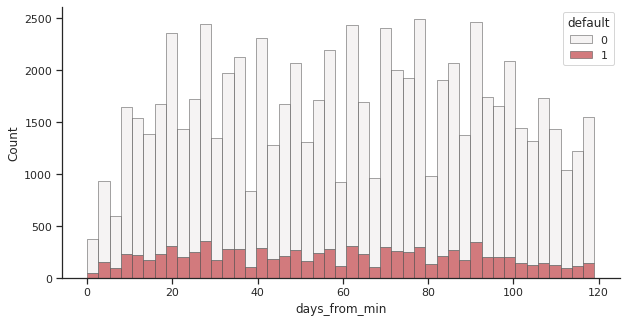

In [25]:
# Посмотрим на распределение дефолтных клиентов по датам
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)

sns.histplot(
    data[data['sample'] == 1],
    x="days_from_min", hue="default",
    multiple="stack",
    palette="light:r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False
)

<AxesSubplot:xlabel='month', ylabel='Count'>

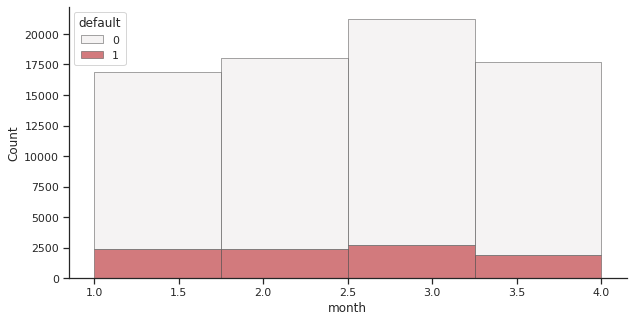

In [26]:
# Посмотрим на распределение дефолтных клиентов по датам
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)

sns.histplot(
    data[data['sample'] == 1],
    x="month", hue="default",
    multiple="stack",
    palette="light:r",
    bins=4,
    edgecolor=".3",
    linewidth=.5,
    log_scale=False
)

In [27]:
data.sample(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,days_from_min,month
84514,81574,2014-03-29,GRD,F,34,N,N,0,0,-2.691100,...,1,1,20000,1,4,Y,1,0,87.0,3
84438,44222,2014-02-20,GRD,M,33,N,N,0,0,-2.824874,...,1,2,23000,1,3,N,1,0,50.0,2
87204,394,2014-01-03,GRD,M,25,N,N,0,0,-1.504557,...,1,3,50000,1,3,N,1,0,2.0,1


Вывод: 
* Данные предоставлены за небольшой промежуток времени (за 4 месяца года)
* в 3-м месяце выдавали большее количество кредитов
* в 4-м месяце процент дефолтных заемщиков заметно снизился.

### 3.2.2 Группировка признаков на категориальные, бинарные и числовые
Посмотрим, какие признаки могут относиться к категориальным, бинарным, числовым.

In [28]:
data.sample(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,days_from_min,month
68391,7375,2014-01-14,SCH,F,33,N,N,0,0,-1.900597,...,2,3,25000,1,4,N,1,0,13.0,1
109441,103034,2014-04-21,PGR,M,38,Y,Y,0,1,-2.744599,...,1,3,150000,4,3,Y,1,0,110.0,4
51606,51388,2014-02-28,SCH,M,45,Y,N,1,0,-1.807447,...,2,3,25000,1,3,N,1,0,58.0,2


In [29]:
# Посмотрим, сколько уникальных значений
data.nunique(dropna=False)

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
days_from_min          120
month                    4
dtype: int64

Исходя из количества уникальных значений, разделим все признаки на группу. 

Категориальные признаки:
* education                
* region_rating            
* home_address             
* work_address             
* sna                      
* first_time               

Бинарные признаки:
* sex                      
* car                      
* car_type                 
* good_work               
* foreign_passport         

Числовые признаки:
* age
* decline_app_cnt
* score_bki
* bki_request_cnt
* region_rating (возможно, категориальный)
* income
* date_from_max

Даты:
* app_date (ранее обработаны)

Служебный признак (не анализируем):
* client_id (id)

In [30]:
# бинарные признаки
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education',  'home_address', 'work_address',
            'sna', 'first_time', 'region_rating', 'month']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt',
            'income', 'score_bki', 'days_from_min']

### 3.2.3. Числовые переменные: распределение, корреляционный анализ, определение значимости

##### Распределние численных признаков

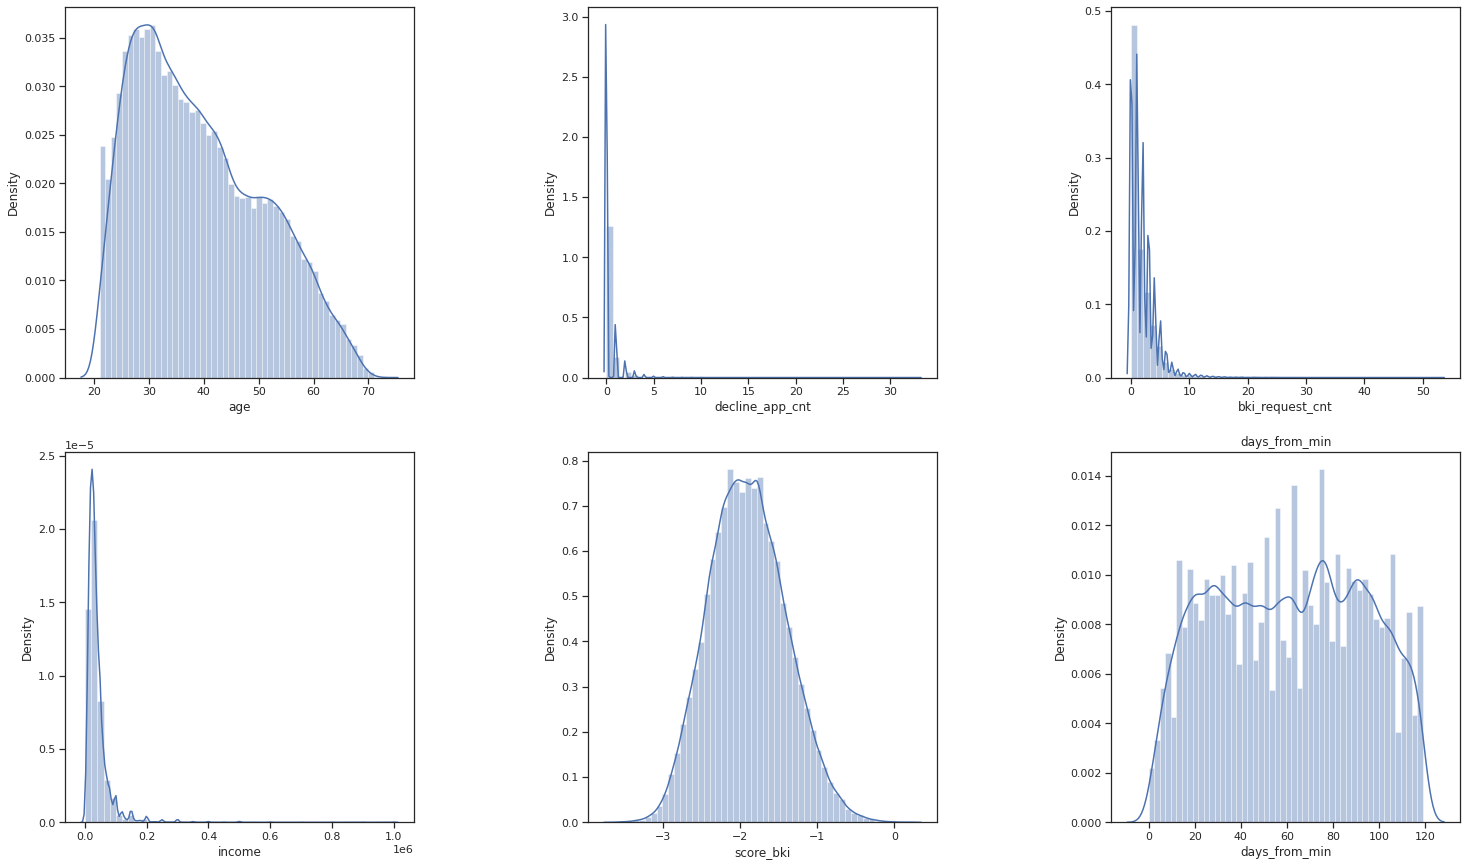

In [31]:
# Построим распределение основных числовых признаков

fig, axes = plt.subplots(2, 3, figsize=(25, 15))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in num_cols:
    sns.distplot(data[col], ax=axes[i])
    plt.title(col)
    i = i + 1

Выводы:
1. После построения гистограмм стало очевидно, что распределения основных числовых переменных имеют тяжёлый правый хвост. Для того, чтобы сделать распределение данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных. Тогда сможем избежать чувствительности к сильным отклонениям в суммах у линейных моделей.
2. Переменные score_bki, days_from_min имеют нормальное распределение

Построем boxplot’ы для численных переменных.

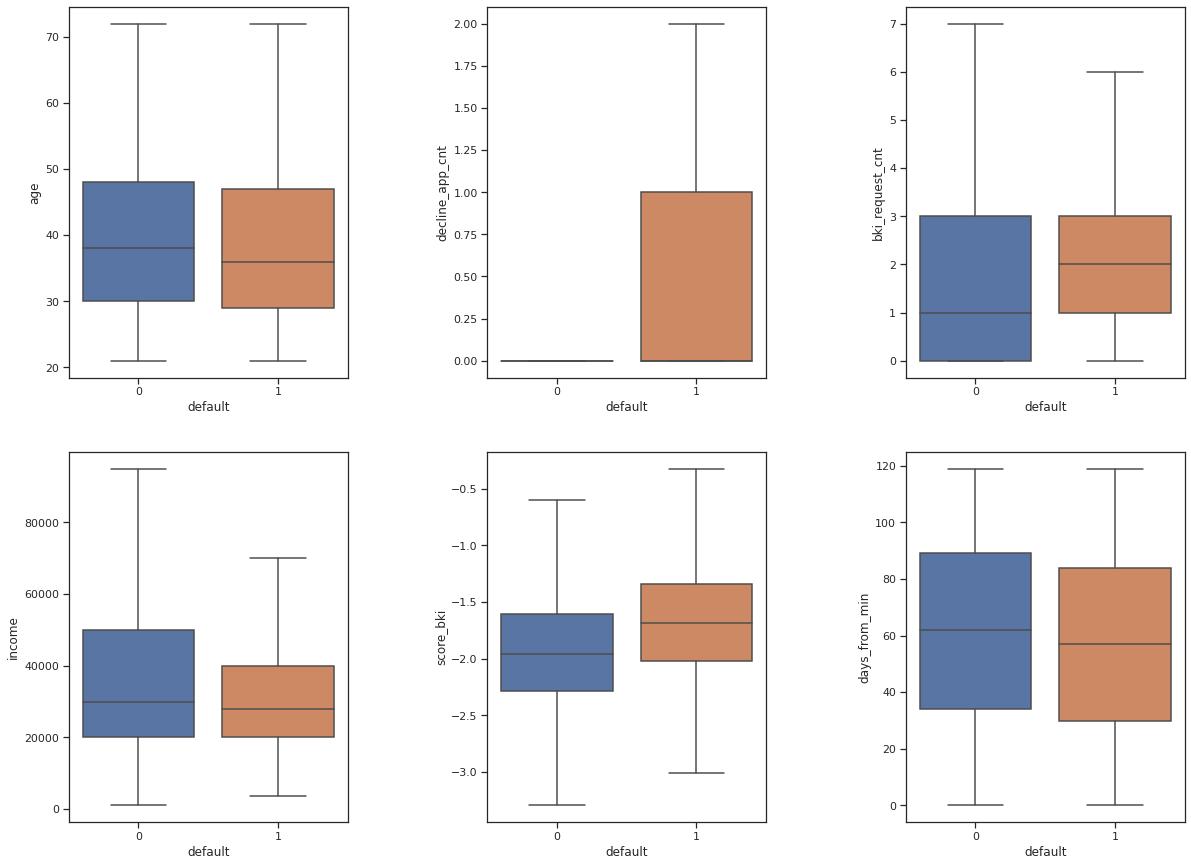

In [32]:
# Построем boxplot’ы для численных переменных.
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()

for i in range(len(num_cols)):
    sns.boxplot(x='default', y=num_cols[i], data=data[data['sample'] == 1],
                orient='v', ax=axes[i], showfliers=False)

Выводы:
1. Дефолтные клиенты в среднем чуть младше
2. Дефолтные клиенты в среднем имеют большее количество отмененных заявок
3. Дефолтные клиенты в среднем имеют больше запросов в БКИ
4. Дефолтные клиенты в среднем имеют более низкий доход
5. Дефолтные клиенты в среднем имеют более высокий скоринговый балл по данным из БКИ
6. Большее количество дефолтных клиентов в начале отчетного периода в данных. Можно предположить, что была изменена политика выдачи займов.

##### Корреляционный анализ.
Оценим корреляцию Пирсона для непрерывных переменных. Cильная корреляция между переменными вредна для линейных моделей из-за неустойчивости полученных оценок.

Text(0.5, 1.0, 'Матрица корреляций')

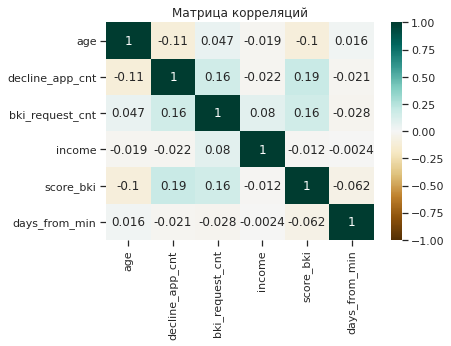

In [33]:
# Построим матрицу корреляций
heatmap = sns.heatmap(data[num_cols].corr(), vmin=-1,
                      vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций')

Вывод: взаимосвязь пар числовых признаков по Пирсону слабая. Максимальный коэффициент 0.21. Это очень здорово для нашей линейной модели.

##### Значимость непрерывных переменных
Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn. 

Возможности модуля sklearn.feature_selection могут быть использованы не только для выбора важных признаков, но и для уменьшения размерности, улучшения предсказательной силы моделей, либо для повышения их производительности на очень многомерных наборах данных.

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t). 

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

<AxesSubplot:>

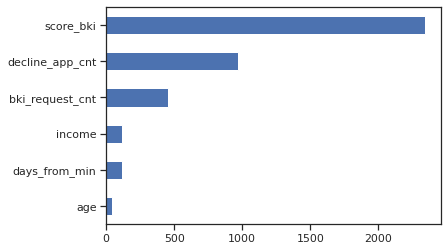

In [34]:
# Посмотрим на значимость числовых признаков на датафрейме data из df_train

imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols], data[data['sample'] == 1]['default'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Вывод: самый значимый из числовых признаков - score_bki.

### 3.2.4. Категориальные и бинарные переменные: конвертация в числовые, определение значимости

##### Преобразование бинарных переменных в числа

Чтобы алгоритмы машинного обучения могли работать с категориальными данными, их нужно преобразовать в числа.
Применим LabelEncoder ко всему набору бинарных переменных.

In [35]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# Убедимся в преобразовании
data.sample(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,days_from_min,month
37276,12297,2014-01-20,GRD,0,50,0,0,0,0,-0.919971,...,2,3,45000,1,3,0,1,0,19.0,1
26926,48547,2014-02-25,GRD,0,49,0,0,0,0,-1.444652,...,1,2,16000,1,4,0,0,0,55.0,2
78298,10988,2014-01-18,SCH,1,44,1,0,0,1,-1.648138,...,1,2,15000,1,4,0,1,0,17.0,1


##### Распределение бинарных и категориальных переменных, зависимость с default

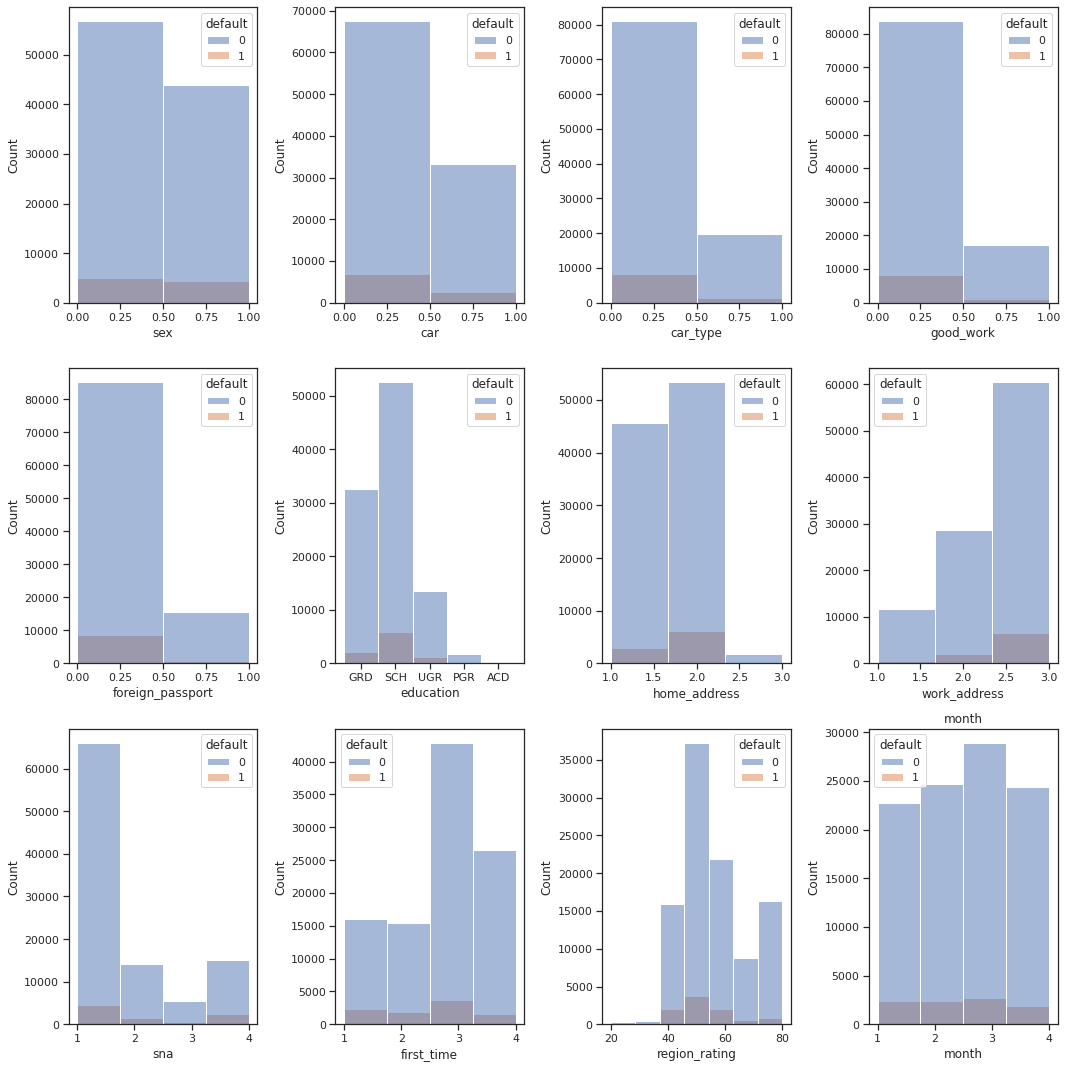

In [36]:
# Построим распределение основных бинарных и категориальных признаков

fig, axes = plt.subplots(3, 4, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in (bin_cols + cat_cols):
    sns.histplot(x=data[col], data=data, ax=axes[i],
                 stat='count', bins=data[col].nunique(), hue='default')
    plt.tight_layout()
    plt.title(col)
    i = i + 1

Выводы:
1. Сбалансированные признаки: sex
2. Особо несбалансированные признаки: car, cat_type, good_work, foreign_passport
3. Сбалансированные рейтинги с заметно превалирующим классом:
    * region_rating: 50 - большое количество
    * sna: 1 - больше остальных
    * first_time: 3 - больше остальных
4. Зависимость с целевой переменной:
    * Нет значительной зависимости дефолтных клиентов от пола
    * Дефолтные клиенты в среднем не имеют машины, заграничного паспорта и хорошей работы. В случае наличия машины, дефолтные клиенты чаще те, у кого отечественный автомобиль, а не иномарка
    * Дефолтные клиенты чаще живут в областях категории 2, а работают в областях категории 3
    * Дефолтные клиенты чаще встречаются у людей со школьным (SCH) образованием, но и заемщиков с таким образованием больше всего.

##### Корреляционный анализ.
Оценим корреляцию Пирсона для категориальных и банарных переменных. Cильная корреляция между переменными вредна для линейных моделей из-за неустойчивости полученных оценок.

Text(0.5, 1.0, 'Матрица корреляций')

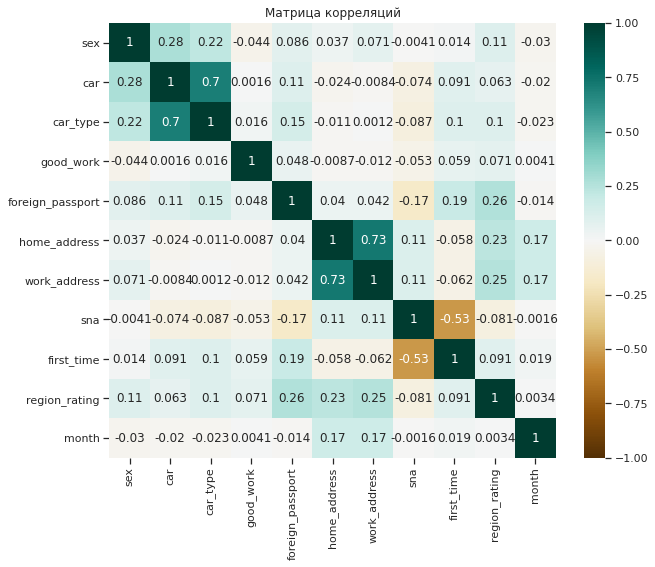

In [37]:
# Построим матрицу корреляций
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(data[bin_cols + cat_cols].corr(),
                      vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций')

Выводы:
1. car и car_type - достаточно скоррелированные признаки (0.7) и это логично, ведь car_type актуален для тех заемщиков, у кого car = 1. Попробуем объединить оба признака в один.
2. home_address и work_address сильно скоррелированы (0.73). Нужно исследовать и подумать про объединение признаков.
3. Незначительная корреляция region_rating (0.23-0.25) с home_address, work_address, foreign_passport.

Посмотрим внимательнее на заемщиков и признаки **car, car_type**.

Text(0.5, 1.0, 'Распределение заемщиков по наличию машины с разбиением иномарка или нет')

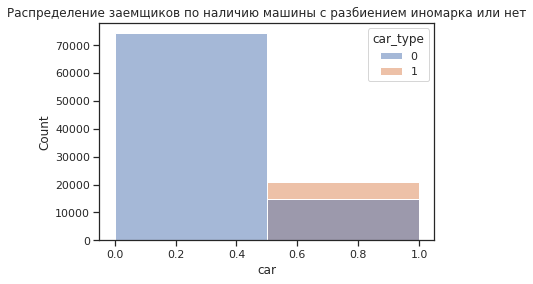

In [38]:
# Построим график
sns.histplot(x=data['car'], data=data,  stat='count', bins=2, hue='car_type')
plt.title('Распределение заемщиков по наличию машины с разбиением иномарка или нет')

Вывод: можно создать новый признак car_info со значениями 0 - машины нет, 1 - машина отчественная, 2 - машина иномарка.

Посмотрим внимательнее на заемщиков и признаки **home_address, work_address**.

Text(0.5, 1.0, 'Распределение заемщиков по рабочим и домашним адресам')

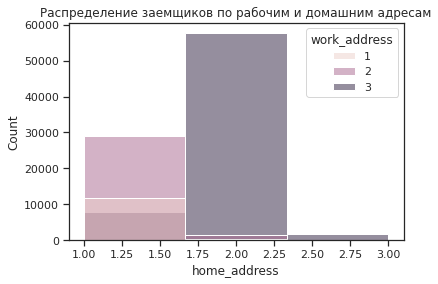

In [39]:
# Построим график
sns.histplot(x=data['home_address'], data=data,
             stat='count', bins=3, hue='work_address')
plt.title('Распределение заемщиков по рабочим и домашним адресам')

Распределение смешанное: 
* большинство заемщико живет во 2-ом районе, работают они в основном в 3-м
* живущие в 1-м районе, в основном работают в 1 и 2 районах
* очень маленькая доля живет в 3 районе и там же работает.
* из предыдущих графиков помним, что большинство дефолтных заемщиков живут во 2-м и работают в 3-м районах.

Попробуем метод главных компонент (PCA) для объединения этих признаков и снижения размерности всех нецелевых переменных. Будем опробовано далее в части генерации новых признаков.

##### Значимость непрерывных переменных
Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

In [40]:
# Для начала преобразуем признак education в числовой
data['education'] = label_encoder.fit_transform(data['education'])

<AxesSubplot:>

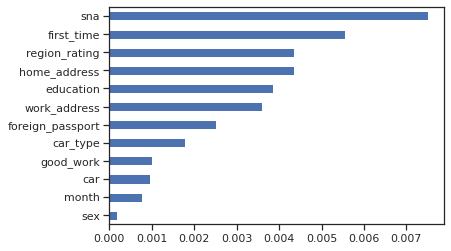

In [41]:
# Оценим значимость бинарных и категориальных признаков
imp_cat = pd.Series(mutual_info_classif(
    data[data['sample'] == 1][bin_cols + cat_cols], data[data['sample'] == 1]['default'], discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Вывод: по мнению mutual_info_classif самым важным признаком является sna, самым менее важным - sex.

<a id="4.3"></a>

## 4.3 Target Analysis
Проанализируем целевую переменную 'default'.

count    73799.000000
mean         0.126994
std          0.332968
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

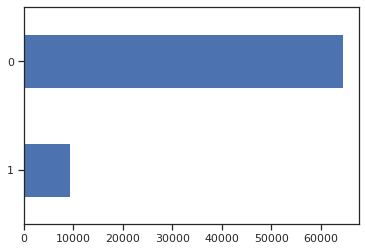

In [42]:
# Посмотрим на распределение целевой переменной
df_train['default'].value_counts(ascending=True).plot(kind='barh')
df_train['default'].describe()

In [43]:
df_train['default'].value_counts(normalize=True)

0    0.873006
1    0.126994
Name: default, dtype: float64

In [44]:
df_train.groupby('default').mean()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample
default,,,,,,,,,,,,,
0,55614.538082,39.390504,0.240877,0.171031,-1.938048,1.933134,57.169044,1.558477,2.474816,41799.713288,1.679405,2.806106,1.0
1,51861.805484,38.525395,0.515472,0.122706,-1.675637,2.462335,53.677977,1.692595,2.643833,36288.113316,2.104033,2.486022,1.0


Выводы:
* Признак бинарный (0, 1). У банка значительно больше клиентов без дефолта (87% против 13%).
* Классы не сбалансированы. Прежде чем перейдём к балансировке, проведём дополнительное исследование.

<a id="4"></a>
# 4. NAIVE MODEL

##### Создание и обучение модели
Прежде, чем переходить к feature engineering построим модель логистической регрессии на "сырых данных" с гиперпараметрами "по умолчанию".

В модели уже учтены стандартизация и кодирование категориальных переменных.

In [45]:
# Препроцесиинг на всём наборе изначальных данных
df_preproc = preproc_data(data)

In [46]:
# Теперь выделим тестовую часть
X, y, cols = data_preparing(df_preproc, prep_type='train', cols_update=False)

Перед тем, как отправлять  данные на обучение, разделим данные на еще один тест и трейн, для валидации. 

In [47]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [48]:
# Создаём модель
model = LogisticRegression(solver='liblinear', random_state=RANDOM_SEED)

In [49]:
# Обучим модель, получим предсказания на тесте
y_pred, probs = log_model_use(model, X_train, X_test, y_train, y_test)

##### Анализ метрик модели


МЕТРИКИ МОДЕЛИ 

Основные метрики

                  precision    recall  f1-score   support

non-default (0)       0.88      0.99      0.93     12933
    default (1)       0.36      0.02      0.04      1827

       accuracy                           0.87     14760
      macro avg       0.62      0.51      0.49     14760
   weighted avg       0.81      0.87      0.82     14760



ROC-кривая



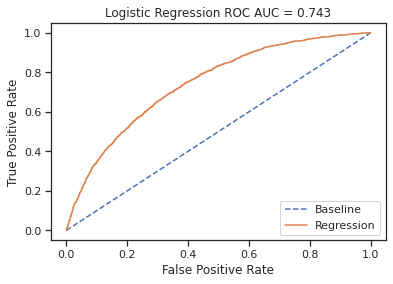



Матрица ошибок



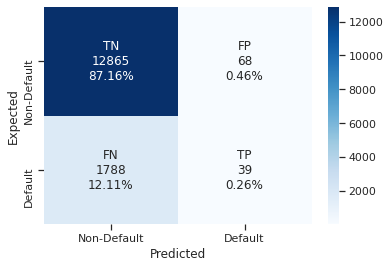

In [50]:
# Посмотрим на метрики модели
roc_auc, accuracy, precision, recall, f1, f1_def = model_metrics(
    y_test, y_pred, probs)

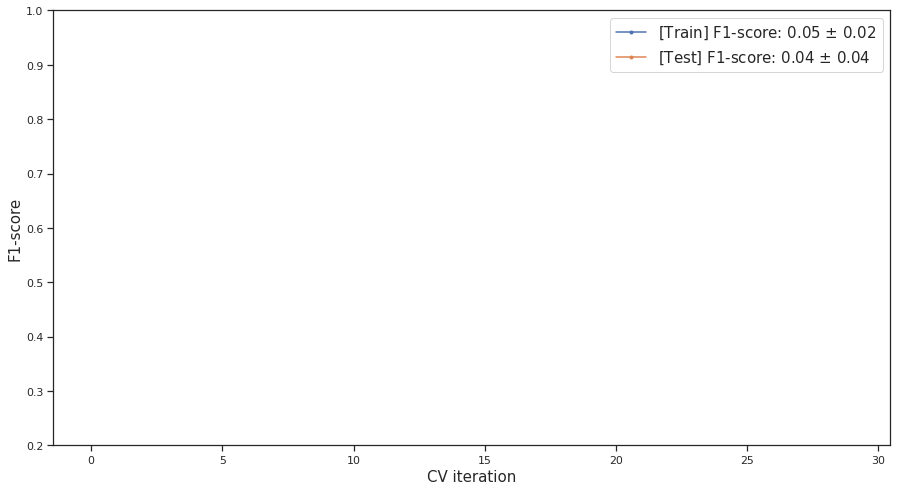

In [51]:
# Проведем кросс-валидацию на трейне и тесте
cross_validation(model, X_train, X_test, y_train, y_test)

In [52]:
# Создадим датафрейм для сохранения результатов экспериментов
ml_report = pd.DataFrame(data=None)

In [53]:
# Добавим эксперимент в отчет
ml_report = generate_report(ml_report, roc_auc, accuracy,
                            precision, recall, f1, f1_def, 'LogisticRegression_Naive')
ml_report

,ROC-AUC,F1-Score,F1-Score Default,Precision,Recall,Accuracy
LogisticRegression_Naive,0.743,0.487,0.04,0.621,0.508,0.874


Выводы:
1. Метрики:
    * ROC-AUC - 0.746, accuracy - 0.874, что является хорошим значением 
    * Метрика F1-Score - 0.491, при этом F1-Score для '1' - 0.048
    * Матрица ошибок показывает, что модель не угадывает дефолтных клиентов, тем самым делает ошибку второго рода, что приведет банки к огромным убыткам.
    * Причина таких результатов - несбалансированность входных данных, к которым чувствителен алгоритм логистической регрессии.
2. Эффективность алгоритма низкая, требуется доработка.

<a id="5"></a>
# 5. MODEL IMPROVEMENTS

План экспериментов:
1. Создание новых фичей, обработка выбросов, логарифмирование
2. Сокращение количества признаков для обучения (корреляционный анализ, тест стьюдента, sklern RFE)
3. Решение проблемы несбалансированности данных по целевой переменной over/under-sampling
4. Подбор гиперпараметров модели.

<a id="5.1"></a>

## 5.1 Model with Feature Engineering, IQR Analysis

### 5.1.1. Генерация новых признаков

По результатам анализа было решено добавить признаки.

##### Признак car_info 
Создадим новый признак car_info со значениями 0 - машины нет, 1 - машина отечественная, 2 - машина иномарка.

In [54]:
# Создаем новый признак car_info
data['car_info'] = data['car'] + data['car_type']

# Добавим новый признак в список категориальных признаков
cat_cols.append('car_info')

data.sample(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,sample,default,days_from_min,month,car_info
1418,109202,2014-04-29,3,0,56,0,0,0,0,-1.679251,...,3,28000,1,3,0,0,0,118.0,4,0
14689,93633,2014-04-09,3,0,31,0,0,1,0,-2.387268,...,3,10000,1,3,0,0,0,98.0,4,0
40789,79845,2014-03-27,1,1,28,1,1,0,0,-1.925173,...,3,40000,4,3,0,1,0,85.0,3,2


Text(0.5, 1.0, 'car_info')

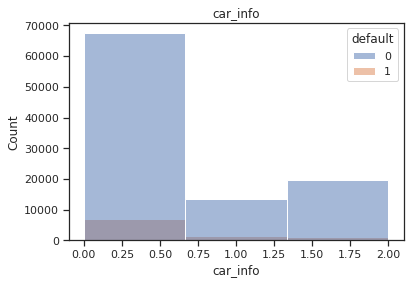

In [55]:
# Посмотрим на распределение нового признака с учетом дефолтности заемщиков
sns.histplot(x=data['car_info'], data=data,
             stat='count', bins=3, hue='default')
plt.title('car_info')

<AxesSubplot:>

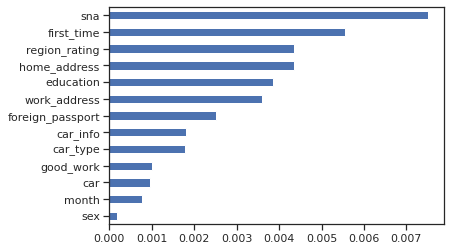

In [56]:
# Оценим значимость бинарных и категориальных признаков после добавления
imp_cat = pd.Series(mutual_info_classif(
    data[data['sample'] == 1][bin_cols + cat_cols], data[data['sample'] == 1]['default'], discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Вывод: car_info более значим, чем отдельные признаки car и car_type. Оставляем новый признак.

In [57]:
data.sample(1)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,sample,default,days_from_min,month,car_info
64601,45360,2014-02-21,4,1,24,0,0,0,0,-0.982228,...,3,30000,2,2,0,1,0,51.0,2,0


##### Признак home_work_address
Создадим новый признак home_work_address с помощью метода главных компонент.

In [58]:
# Отберем значения с адресами
address_data = data[['work_address', 'home_address']].values

# Стандартизируем значения
scaler = StandardScaler()
address_data_s = scaler.fit_transform(address_data)

# Из двух веторов построим один с наиболее значимыми
pca = PCA(n_components=1)
pca.fit(address_data_s)
pca_address = pca.transform(address_data_s)
data['home_work_address'] = pca_address

Text(0.5, 1.0, 'home_work_address')

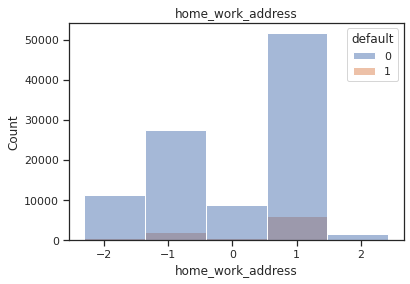

In [59]:
# Посмотрим на распределение нового признака с учетом дефолтности заемщиков
sns.histplot(x=data['home_work_address'], data=data,
             stat='count', bins=5, hue='default')
plt.title('home_work_address')

In [60]:
# Добавим новый признак в список категориальных переменных
cat_cols.append('home_work_address')

<AxesSubplot:>

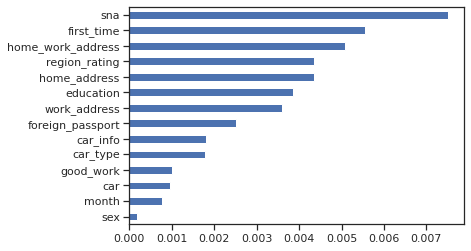

In [61]:
# Оценим значимость бинарных и категориальных признаков после добавления
imp_cat = pd.Series(mutual_info_classif(
    data[data['sample'] == 1][bin_cols + cat_cols], data[data['sample'] == 1]['default'], discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Вывод: home_work_address более значим, чем отдельные признаки home_address и work_address. Оставляем новый признак, старые удаляем.

In [62]:
data.sample()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,sample,default,days_from_min,month,car_info,home_work_address
7314,34273,2014-02-10,1,1,31,1,1,0,0,-1.650742,...,70000,1,4,0,0,0,40.0,2,2,-0.254275


##### Признак age_group

Создадим новый категориальный признак age_group из числового.

In [63]:
# Зададим основные возрастные категории
category = pd.cut(data.age, bins=[0, 2, 17, 35, 65, 99], labels=[
                  'toddler', 'child', 'adult_young', 'adult_old', 'elderly'])
data.insert(4, 'age_group', category)

<AxesSubplot:xlabel='age_group', ylabel='Count'>

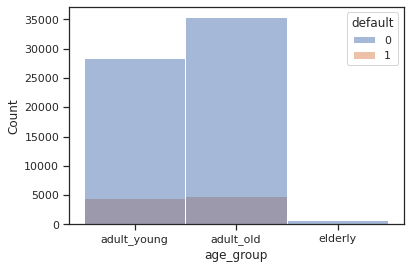

In [64]:
# Посмотрим, как распределены дефолтные заемщики по возрастным категориям
sns.histplot(x=data[data['sample'] == 1]['age_group'],
             data=data[data['sample'] == 1], stat='count', bins=3, hue='default')

In [65]:
# Посмотрим, как распределены дефолтные заемщики в зависимости от возрастной категории и пола
tmp = pd.DataFrame(data[data['sample'] == 1].groupby(
    ['age_group', 'sex'])['default'].value_counts(normalize=True))
tmp

default
age_group   sex default          
adult_young 0   0        0.868911
                1        0.131089
            1   0        0.859720
                1        0.140280
adult_old   0   0        0.885599
                1        0.114401
            1   0        0.871884
                1        0.128116
elderly     0   0        0.874411
                1        0.125589
            1   0        0.842365
                1        0.157635

<AxesSubplot:xlabel='sex', ylabel='Count'>

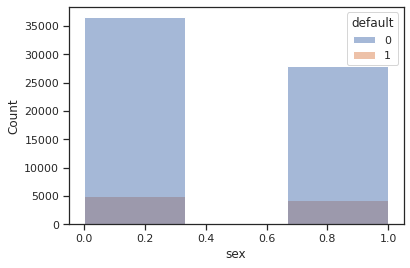

In [66]:
sns.histplot(x=data[data['sample'] == 1]['sex'],
             data=data[data['sample'] == 1], stat='count', bins=3, hue='default')

In [67]:
# Добавим новый признак к категориальным
cat_cols.append('age_group')

In [68]:
# Преобразуем признак age_group в числовой
data['age_group'] = label_encoder.fit_transform(data['age_group'])

<AxesSubplot:>

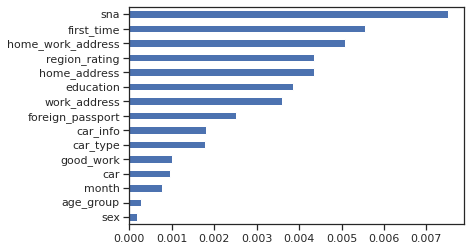

In [69]:
# Оценим значимость бинарных и категориальных признаков с учетом нового признака
imp_cat = pd.Series(mutual_info_classif(
    data[data['sample'] == 1][bin_cols + cat_cols], data[data['sample'] == 1]['default'], discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

##### Признак edu_sex_income, income_cat

Поисследуем признак дохода, его зависимость от других переменных.

count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

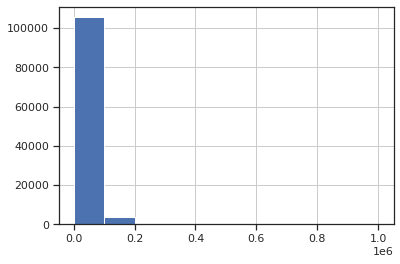

In [70]:
data.income.hist()
data.income.describe()

<AxesSubplot:xlabel='education', ylabel='income'>

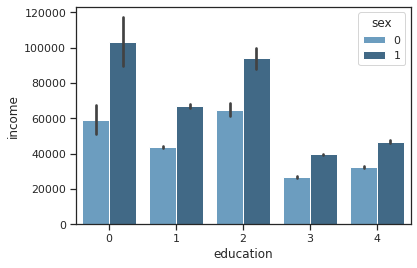

In [71]:
# Посомтрим на средний доход от образования и пола
sns.barplot(x="education", y="income", hue="sex", data=data, palette="Blues_d")

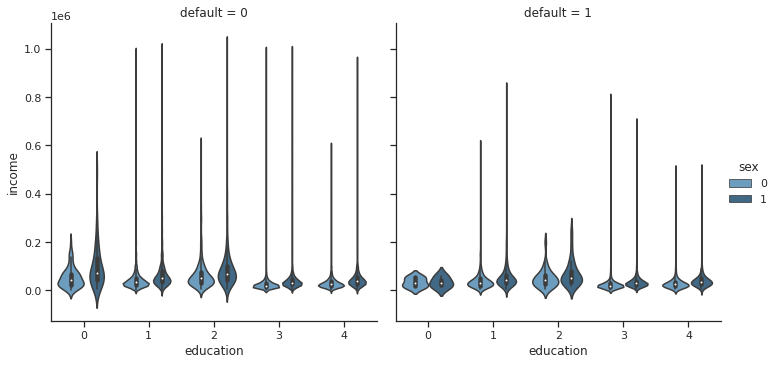

In [72]:
# Посмотрим на скореллированные признаки income, education, sex
sns.catplot(x="education", y="income",
            hue="sex", col="default",
            data=data[data['sample'] == 1], kind="violin", palette="Blues_d")

Вывод: по отдельности, все признаки являются не очень значимыми для модели. Попробуем сделать из трёх признаков один, т.к. заметно увеличение дохода в зависимости от уровня образования, пола.

In [73]:
# Отберем значения с адресами
income_data = data[['education', 'income', 'sex']].values

# Стандартизируем значения
scaler = StandardScaler()
income_data_s = scaler.fit_transform(income_data)

# Из двух трех векторов построим один с наиболее значимыми
pca = PCA(n_components=1)
pca.fit(income_data_s)
pca_income = pca.transform(income_data_s)
data['edu_sex_income'] = pca_income

In [74]:
data['edu_sex_income'].nunique()

2905

Text(0.5, 1.0, 'edu_sex_income')

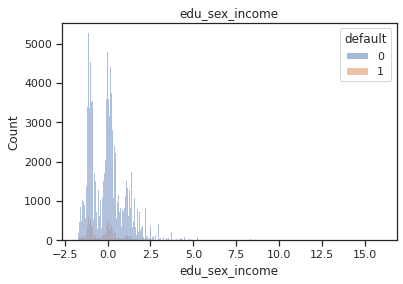

In [75]:
# Посмотрим на распределение нового признака с учетом дефолтности заемщиков
sns.histplot(x=data['edu_sex_income'], data=data, stat='count', hue='default')
plt.title('edu_sex_income')

In [76]:
# Добавим новый признак в список категориальных переменных
num_cols.append('edu_sex_income')

<AxesSubplot:>

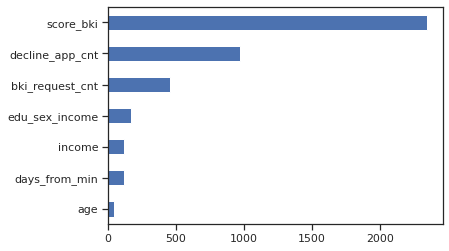

In [77]:
# Посмотрим на значимость числовых признаков на датафрейме data
imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols], data[data['sample'] == 1]['default'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Вывод: новый признак более значимый, чем просто income.

Поскольку у признака есть выбросы, попробуем разбить доход на классы в зависимости от перцентиля.

In [78]:
# Посчитаем минимум, максимум, 25 и 75 перцентили
income_min = data.income.min()
income_max = data.income.max()
income_perc25 = data.income.quantile(0.25)
income_perc75 = data.income.quantile(0.75)
# использую IQR верзхнюю границу
income_huge = income_perc75 + 1.5*(income_perc75 - income_perc25)

print("Минимальный доход:", income_min)
print("25-й перцентиль дохода:", income_perc25)
print("75-й перцентиль дохода:,", income_perc75)
print("Очень высокий доход:", income_huge)
print("Максимальный доход:", income_max)

Минимальный доход: 1000
25-й перцентиль дохода: 20000.0
75-й перцентиль дохода:, 48000.0
Очень высокий доход: 90000.0
Максимальный доход: 1000000


In [79]:
# Зададим основные возрастные категории
category_2 = pd.cut(data.income, bins=[income_min, income_perc25, income_perc75, income_huge, income_max], labels=[
                    'low', 'med', 'high', 'extra_high'], include_lowest=True)
data.insert(4, 'income_cat', category_2)

<AxesSubplot:xlabel='income_cat', ylabel='Count'>

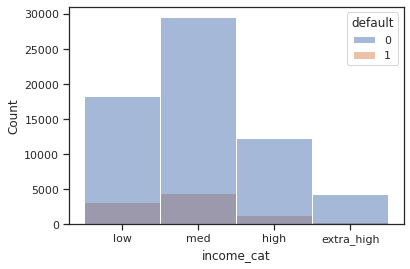

In [80]:
# Посмотрим, как распределены дефолтные заемщики по возрастным категориям
sns.histplot(x=data[data['sample'] == 1]['income_cat'],
             data=data[data['sample'] == 1], stat='count', bins=4, hue='default')

In [81]:
# Добавим новый признак к категориальным
cat_cols.append('income_cat')

In [82]:
# Преобразуем признак income_cat в числовой
data['income_cat'] = label_encoder.fit_transform(data['income_cat'])

<AxesSubplot:>

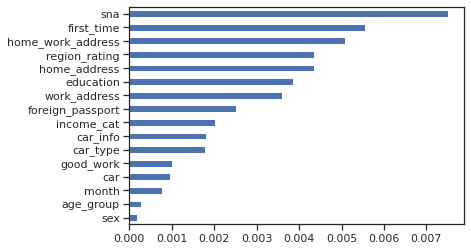

In [83]:
# Оценим значимость бинарных и категориальных признаков с учетом нового признака
imp_cat = pd.Series(mutual_info_classif(
    data[data['sample'] == 1][bin_cols + cat_cols], data[data['sample'] == 1]['default'], discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Вывод: переменная income_cat обладает хорошей значимостью, оставляем.

##### Признаки bki_cat, decline_cat


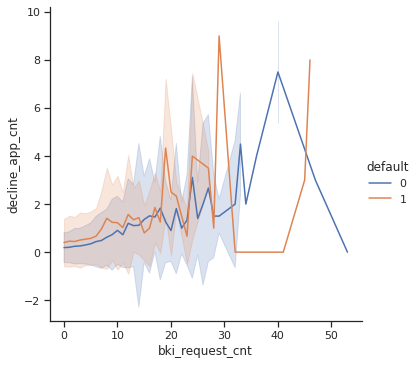

In [84]:
# Посмотрим, есть ли зависимость между количеством средним количество запросов а БКИ и средним количеством отказов с указанием стандартного отклонения
sns.relplot(x="bki_request_cnt", y="decline_app_cnt", kind="line",
            ci='sd', estimator='mean', hue="default", data=data)

Вывод: 
* В среднем, количество отказов по заявкам увеличивается с количеством запросов в БКИ
* В среднем, количество дефолтных клиентов больше для заемщиков с большим количеством отказов.

In [85]:
# Посчитаем минимум, максимум, 25 и 75 перцентили
bki_min = data.bki_request_cnt.min()
bki_max = data.bki_request_cnt.max()
bki_perc25 = data.bki_request_cnt.quantile(0.25)
bki_perc50 = data.bki_request_cnt.quantile(0.5)
bki_perc75 = data.bki_request_cnt.quantile(0.75)
# использую IQR верзхнюю границу
bki_huge = bki_perc75 + 1.5*(bki_perc75 - bki_perc25)

print("Минимальное количество запросов в БКИ:", bki_min)
print("25-й перцентиль запросов в БКИ:", bki_perc25)
print("50-й перцентиль запросов в БКИ:", bki_perc50)
print("75-й перцентиль запросов в БКИ:,", bki_perc75)
print("Очень высокиое количество запросов в БКИ:", bki_huge)
print("Максимальное количество запросов в БКИ:", bki_max)

Минимальное количество запросов в БКИ: 0
25-й перцентиль запросов в БКИ: 0.0
50-й перцентиль запросов в БКИ: 1.0
75-й перцентиль запросов в БКИ:, 3.0
Очень высокиое количество запросов в БКИ: 7.5
Максимальное количество запросов в БКИ: 53


In [86]:
# Зададим основные возрастные категории
category_3 = pd.cut(data.bki_request_cnt, bins=[bki_min, bki_perc50, bki_perc75, bki_huge, bki_max], labels=[
                    'low', 'med', 'high', 'extra_high'], include_lowest=True)
data.insert(4, 'bki_cat', category_3)

<AxesSubplot:xlabel='bki_cat', ylabel='Count'>

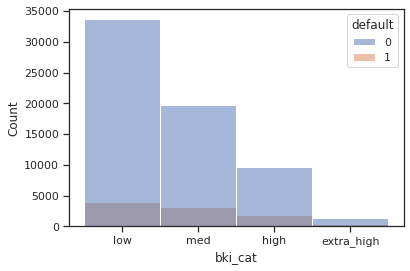

In [87]:
# Посмотрим, как распределены дефолтные заемщики по bki_cat категориям
sns.histplot(x=data[data['sample'] == 1]['bki_cat'],
             data=data[data['sample'] == 1], stat='count', bins=4, hue='default')

In [88]:
# Добавим новый признак к категориальным
cat_cols.append('bki_cat')

In [89]:
# Преобразуем признак bki_cat в числовой
data['bki_cat'] = label_encoder.fit_transform(data['bki_cat'])

<AxesSubplot:>

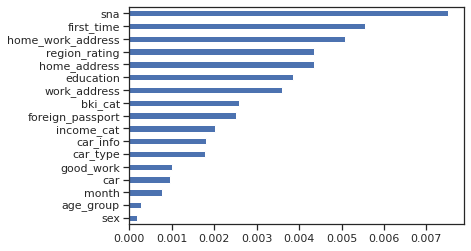

In [90]:
# Оценим значимость бинарных и категориальных признаков с учетом нового признака
imp_cat = pd.Series(mutual_info_classif(
    data[data['sample'] == 1][bin_cols + cat_cols], data[data['sample'] == 1]['default'], discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Вывод: переменная bki_cat обладает хорошей значимостью, оставляем.

In [91]:
# Посмотрим, какое количество отказов у 99% заемщиков из банка
dec_99_quantile = data.decline_app_cnt.quantile(0.99)
dec_99_quantile

4.0

Создадим категории: 0 - нет отказов, 1 - 1 отказ, 2 - 2 отказа, 3 - 3 отказа, 4 - 4 и более отказов.

In [92]:
# Добавляем новый признак
data['decline_cat'] = data['decline_app_cnt'].apply(
    lambda x: 4 if x >= dec_99_quantile else x)

<AxesSubplot:xlabel='decline_cat', ylabel='Count'>

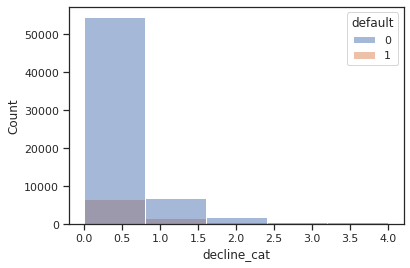

In [93]:
# Посмотрим, как распределены дефолтные заемщики по decline_cat категориям
sns.histplot(x=data[data['sample'] == 1]['decline_cat'],
             data=data[data['sample'] == 1], stat='count', bins=5, hue='default')

In [94]:
# Добавим новый признак к категориальным
cat_cols.append('decline_cat')

<AxesSubplot:>

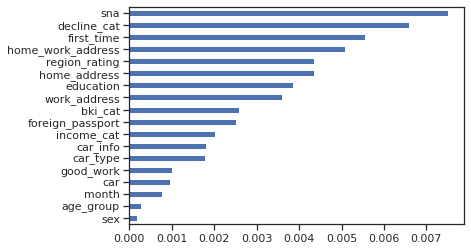

In [95]:
# Оценим значимость бинарных и категориальных признаков с учетом нового признака
imp_cat = pd.Series(mutual_info_classif(
    data[data['sample'] == 1][bin_cols + cat_cols], data[data['sample'] == 1]['default'], discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Вывод: переменная decline_cat обладает очень высокой значимостью, оставляем.

##### Признак relations
Корреляционный анализ показал отрицательную коррелцию между признаками sna и first_time (-0.5). Чем более новый клиент, тем меньше связь клиента с заемщиками банка.

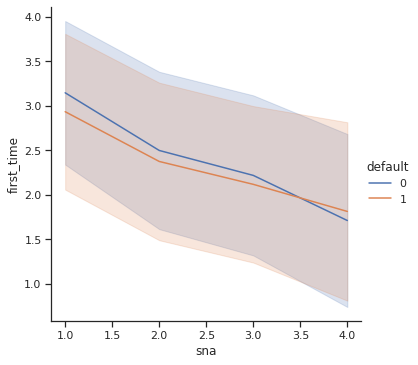

In [96]:
# Посмотрим, есть ли зависимость между количеством средним количество запросов а БКИ и средним количеством отказов с указанием стандартного отклонения
sns.relplot(x="sna", y="first_time", kind="line", ci='sd',
            estimator='mean', hue="default", data=data)

In [97]:
# Отберем значения с адресами
relations = data[['sna', 'first_time']].values

# Стандартизируем значения
scaler = StandardScaler()
relations_s = scaler.fit_transform(relations)

# Из двух веторов построим один с наиболее значимыми
pca = PCA(n_components=1, svd_solver='full')
pca.fit(relations_s)
pca_relations = pca.transform(relations_s)
data['relations'] = pca_relations

Text(0.5, 1.0, 'relations')

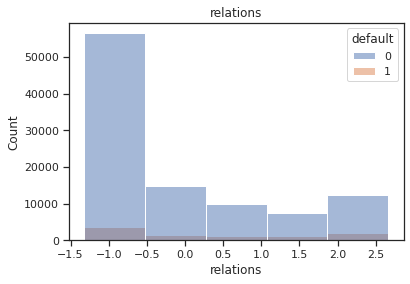

In [98]:
# Посмотрим на распределение нового признака с учетом дефолтности заемщиков
sns.histplot(x=data['relations'], data=data,
             stat='count', bins=5, hue='default')
plt.title('relations')

In [99]:
# Добавим новый признак в список категориальных переменных
num_cols.append('relations')

<AxesSubplot:>

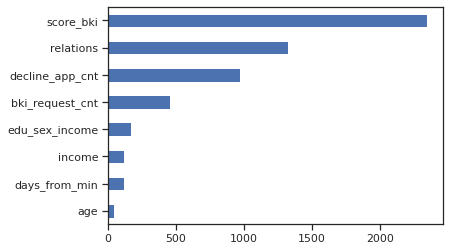

In [100]:
# Посмотрим на значимость числовых признаков на датафрейме data
imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols], data[data['sample'] == 1]['default'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

### 5.1.2. Поиск и обработка выбросов

In [101]:
# Проанализируем выбросы для бинарных и номинативных признаков
for col in (bin_cols + num_cols):
    print("\nПризнак: ", col)
    iqr_analysis(data[col])
    print("-" * 100)


Признак:  sex

25-й перцентиль: 0.0, 
75-й перцентиль: 1.0, 
IQR: 1.0,  
Границы выбросов: [-1.5, 2.5]. 

Минимальное значение признака: 0. 
Максимальное значение признака: 1 .

----------------------------------------------------------------------------------------------------

Признак:  car

25-й перцентиль: 0.0, 
75-й перцентиль: 1.0, 
IQR: 1.0,  
Границы выбросов: [-1.5, 2.5]. 

Минимальное значение признака: 0. 
Максимальное значение признака: 1 .

----------------------------------------------------------------------------------------------------

Признак:  car_type

25-й перцентиль: 0.0, 
75-й перцентиль: 0.0, 
IQR: 0.0,  
Границы выбросов: [0.0, 0.0]. 

Минимальное значение признака: 0. 
Максимальное значение признака: 1 .

Найдены выбросы по верхней границе признака! Количество: 21008, 19.07%
----------------------------------------------------------------------------------------------------

Признак:  good_work

25-й перцентиль: 0.0, 
75-й перцентиль: 0.0, 
IQR: 0.0,  
Грани

<AxesSubplot:xlabel='decline_app_cnt', ylabel='Count'>

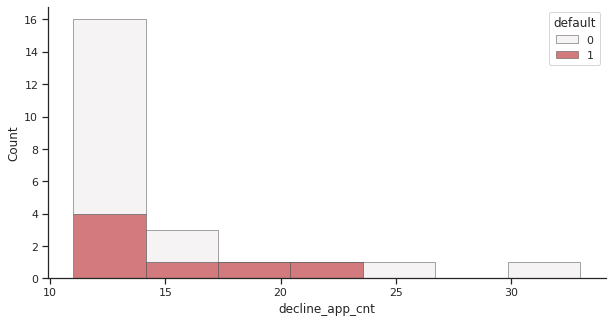

In [102]:
# Посмотрим на распределение дефолтных клиентов по decline_app_cnt > 10
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)

sns.histplot(
    data[(data['sample'] == 1) & (data['decline_app_cnt'] > 10)],
    x="decline_app_cnt", hue="default",
    multiple="stack",
    palette="light:r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False
)

<AxesSubplot:xlabel='bki_request_cnt', ylabel='Count'>

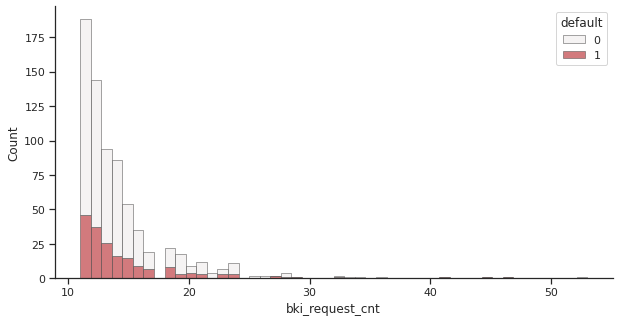

In [103]:
# Посмотрим на распределение дефолтных клиентов по bki_request_cnt > 10
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)

sns.histplot(
    data[(data['sample'] == 1) & (data['bki_request_cnt'] > 10)],
    x="bki_request_cnt", hue="default",
    multiple="stack",
    palette="light:r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False
)

<AxesSubplot:xlabel='income', ylabel='Count'>

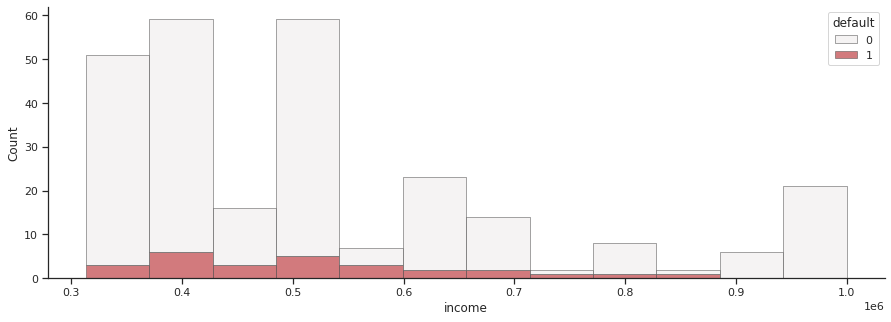

In [104]:
# Посмотрим на распределение дефолтных клиентов по income > 300000
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)

sns.histplot(
    data[(data['sample'] == 1) & (data['income'] > 300000)],
    x="income", hue="default",
    multiple="stack",
    palette="light:r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False
)

Выводы:
1. Найденный выбросы для бинарных признаков выбросами не считаем, т.к. 0 и 1 - это допустимые значения. К таким признакам относятся: car_type, good_work, foreign_passport
2. decline_app_cnt, bki_request_cnt, income - сильный правый хвост, но признаки значимы для модели, удалять выбросы не хочется. Посмотрела, что в хвостовой части пропорция дефолтных клиентов меньше, чем в левой части графика, выглядит, как важные данные. Попробуем логарифмирование.
3. score_bki - значения незначительно превышают верхнюю и нижнюю границы, поэтому выбросы не обрабатываю. Таких выбросов чуть больше 1% от всех данных.

In [105]:
# Применим логарифмирование ко всем числовым признакам, кроме score_bki и regional_rating
for col in (set(num_cols) - set(['score_bki', 'days_from_min', 'edu_sex_income', 'relations'])):
    data[col] = data[col].apply(lambda w: np.log(w+1))

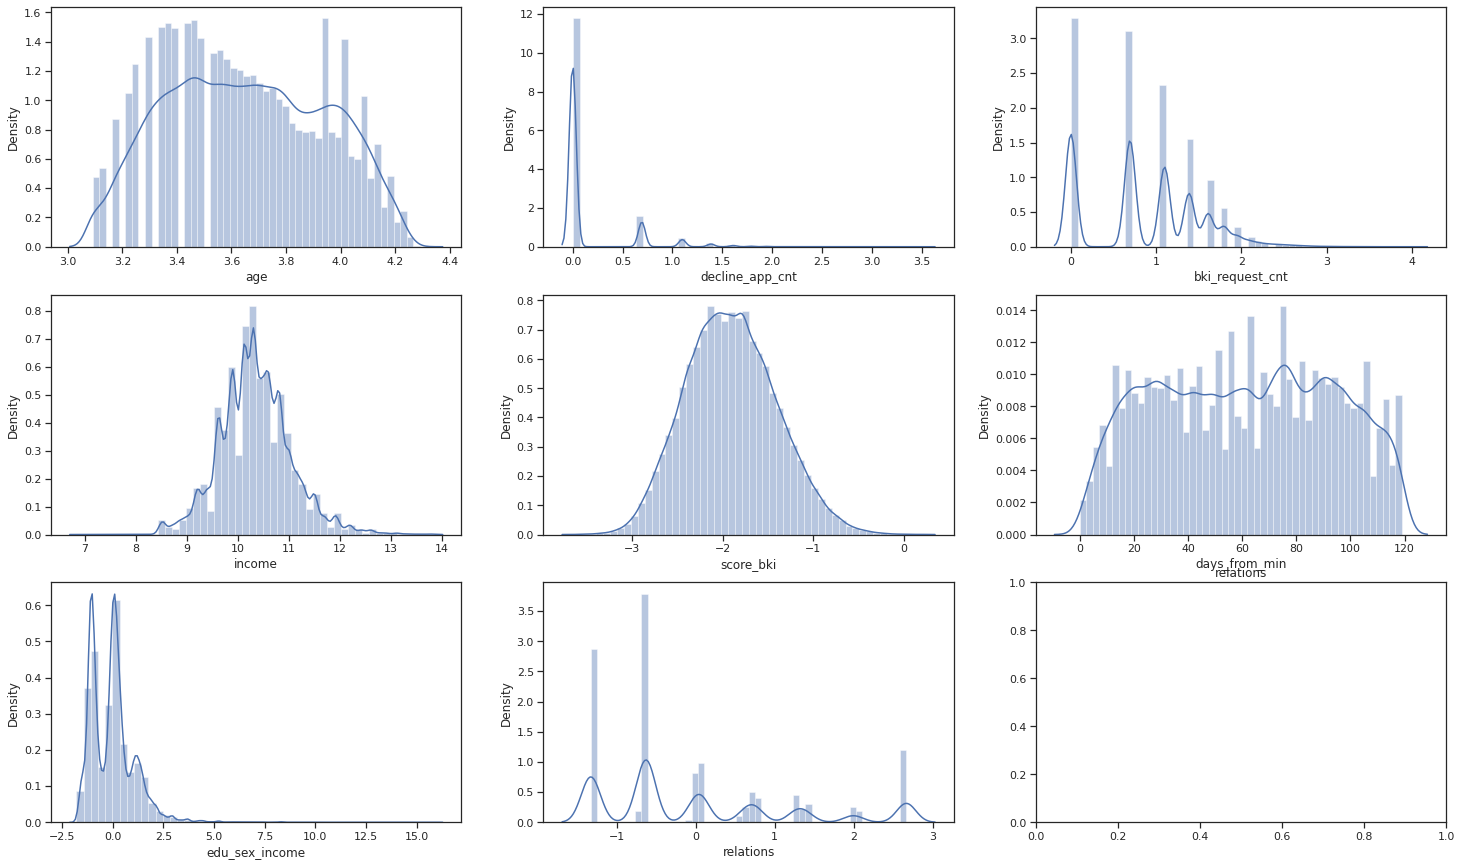

In [106]:
# Посмотрим, как изменилось распределение
fig, axes = plt.subplots(3, 3, figsize=(25, 15))
axes = axes.flatten()
i = 0

for col in num_cols:
    sns.distplot(data[col], ax=axes[i])
    plt.title(col)
    i = i + 1

### 5.1.3. Моделирование после добавления новых признаков


In [107]:
# Предобработка данных
df_preproc = preproc_data(data)
X, y, cols = data_preparing(df_preproc, prep_type='train', cols_update=False)

# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

##### Анализ метрик модели


МЕТРИКИ МОДЕЛИ 

Основные метрики

                  precision    recall  f1-score   support

non-default (0)       0.88      0.99      0.93     12933
    default (1)       0.36      0.02      0.04      1827

       accuracy                           0.87     14760
      macro avg       0.62      0.51      0.49     14760
   weighted avg       0.81      0.87      0.82     14760



ROC-кривая



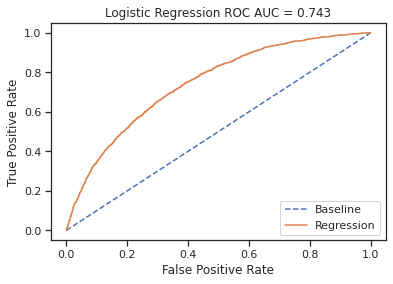



Матрица ошибок



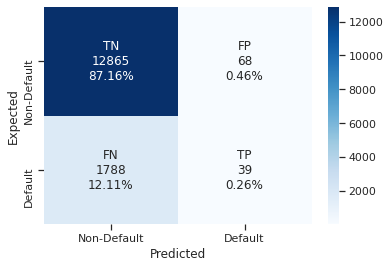

In [108]:
# Посмотрим на метрики модели
roc_auc, accuracy, precision, recall, f1, f1_def = model_metrics(
    y_test, y_pred, probs)

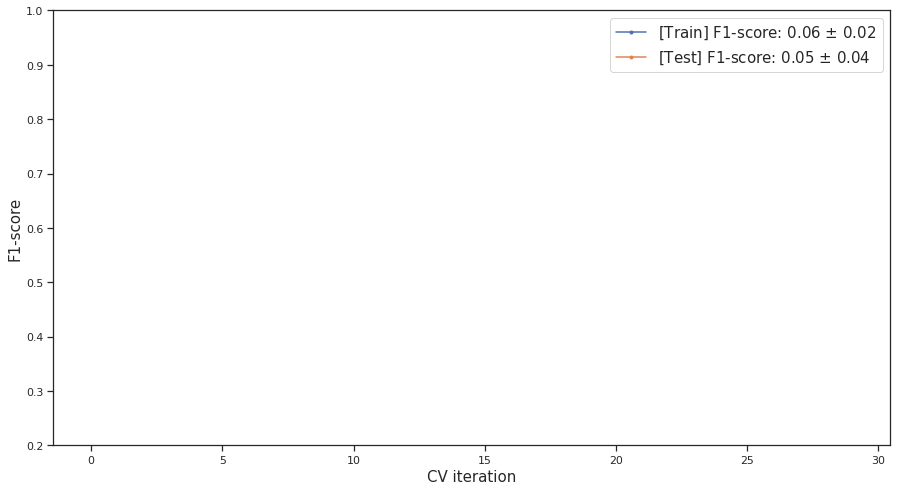

In [109]:
# Делаем кросс-валидацию
cross_validation(model, X_train, X_test, y_train, y_test)

In [110]:
# Добавляем данные эксперимента в итоговый отчет
ml_report = generate_report(ml_report, roc_auc, accuracy, precision,
                            recall, f1, f1_def, 'LogisticRegression_Feature_Engineering')
ml_report

,ROC-AUC,F1-Score,F1-Score Default,Precision,Recall,Accuracy
LogisticRegression_Naive,0.743,0.487,0.04,0.621,0.508,0.874
LogisticRegression_Feature_Engineering,0.743,0.487,0.04,0.621,0.508,0.874


Вывод: 
* Добавление новых признаков позволяет незначительно увеличить ROC_AUC значение, но ошибок второго рода всё еще много. 
* При этом, на кросс-валидации можем наблюдать переобучение модели, т.к. усложнили новыми признаками. 
* Требуется отбор признаков для снижения переобучения. Всё еще неудовлетворительны F1-Score для '1' значения.

<a id="5.2"></a>
## 5.2 Model with Feature Selection: Сorrelation, RFE
Необходимо уменьшить сложность модели посредством отбора признаков.

<a id="5.2.1"></a>

### 5.2.1 Снижение размерности признаков с помощью корреляционного анализа, теста Стьюдента

#### Корреляционный анализ

Text(0.5, 1.0, 'Матрица корреляций')

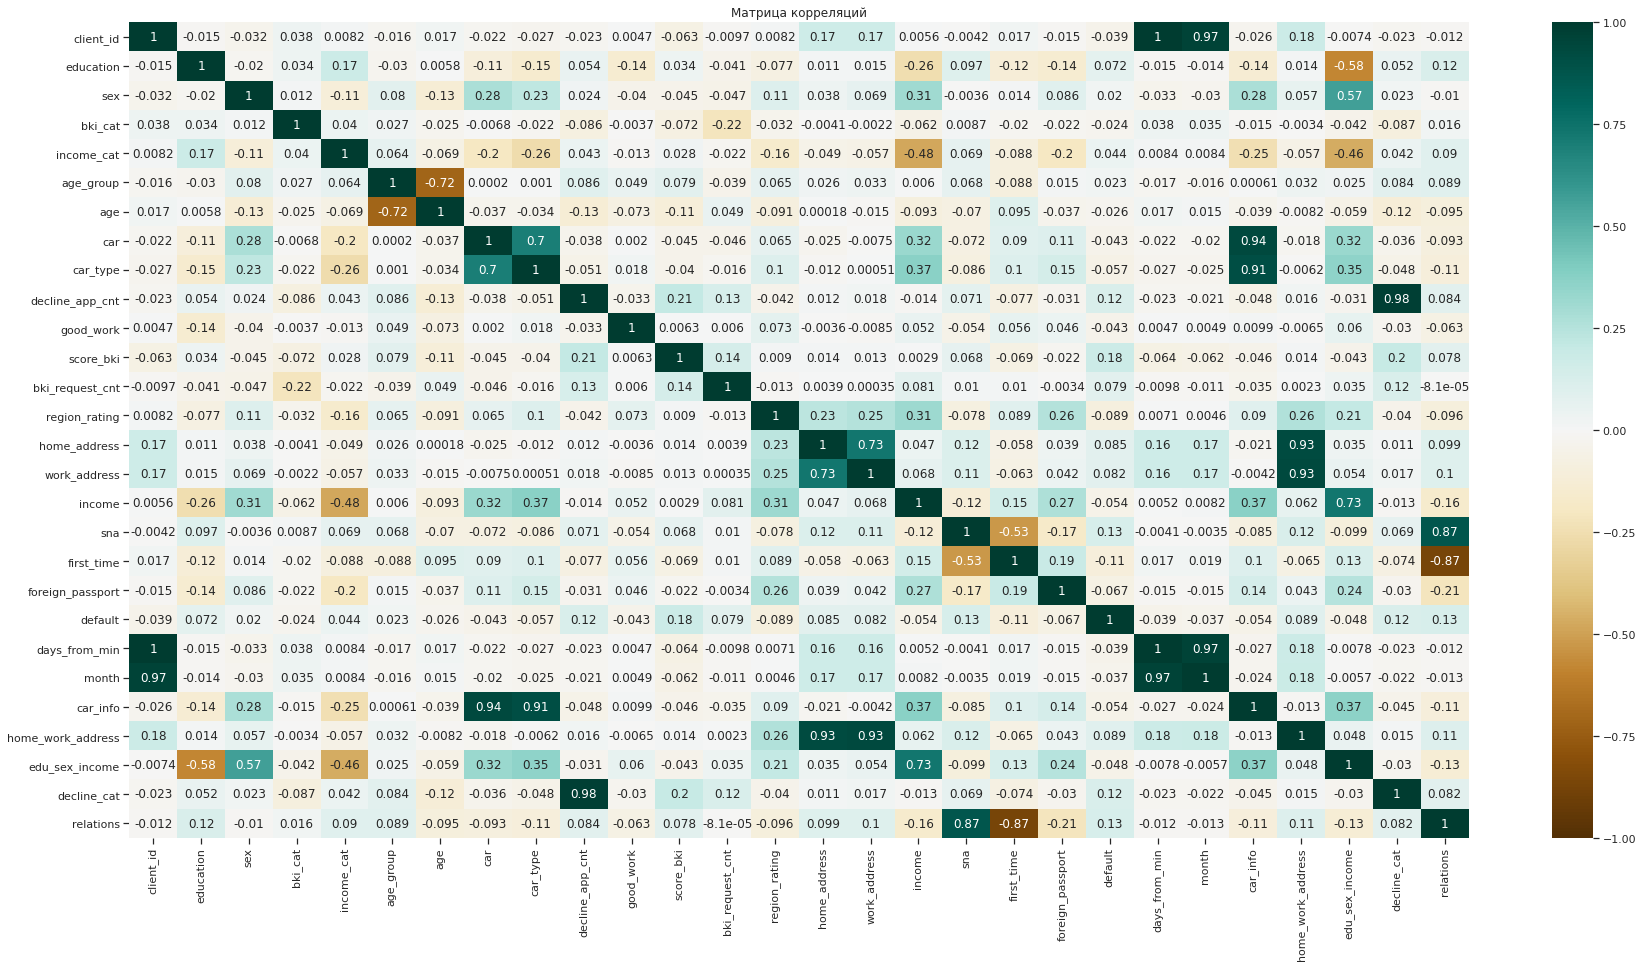

In [111]:
# Построим матрицу корреляций
plt.figure(figsize=(30, 15))
heatmap = sns.heatmap(data[data['sample'] == 1].drop(
    ['sample'], axis=1).corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций')

Text(0.5, 1.0, 'Матрица корреляций, где корреляция > 0.8')

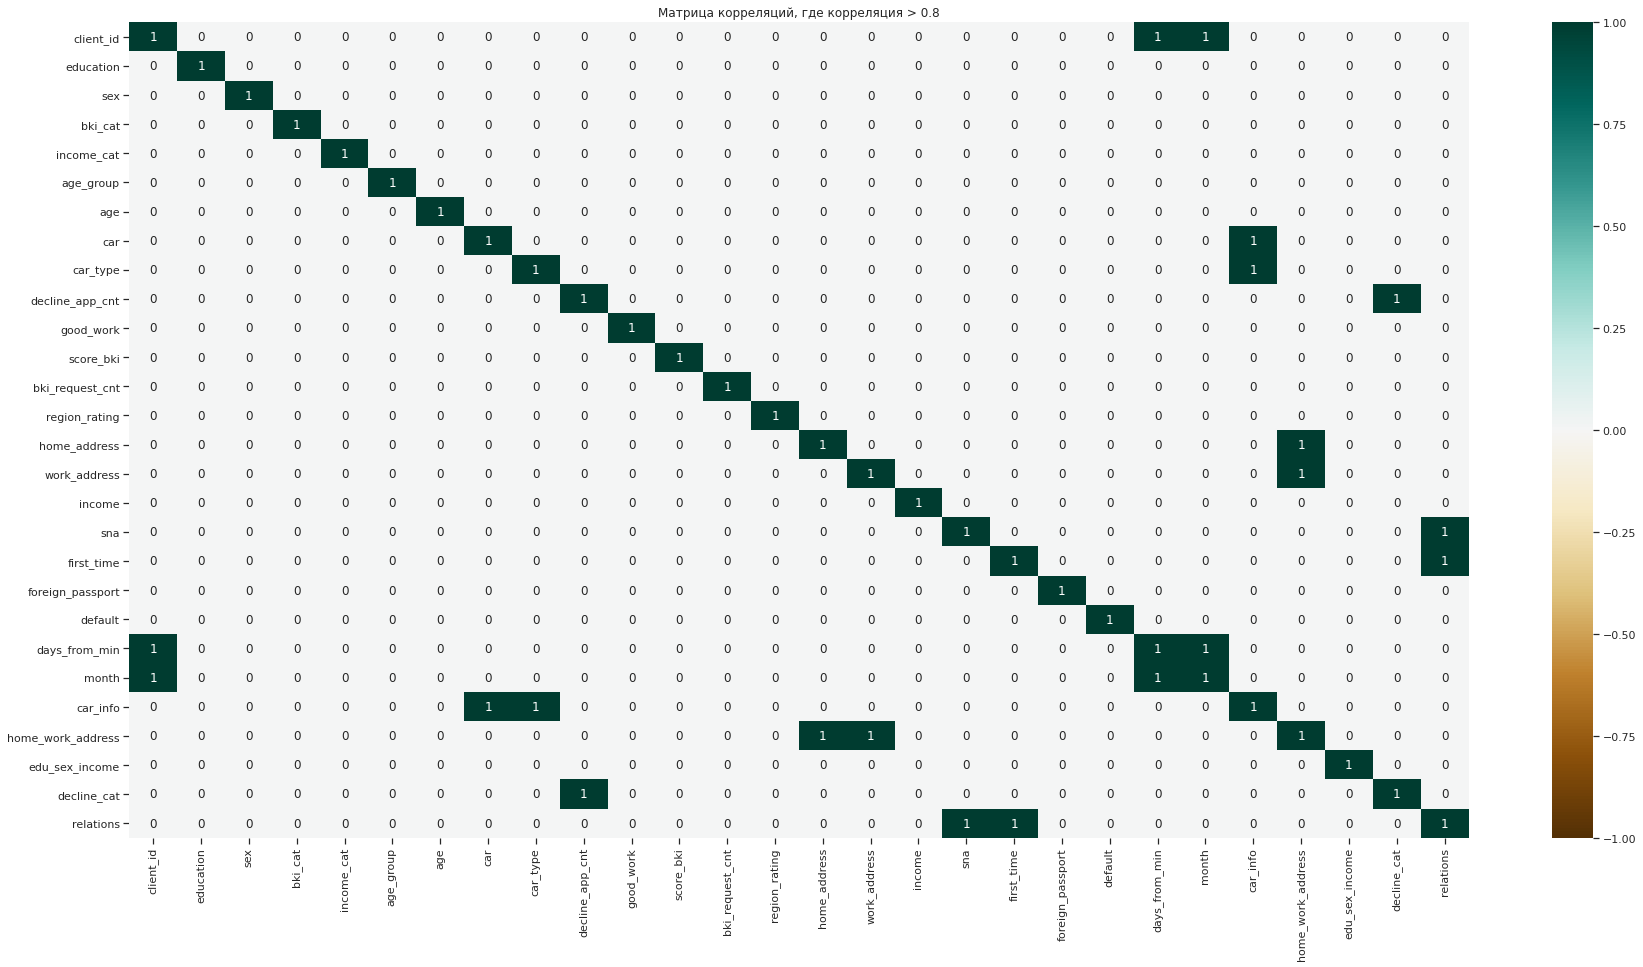

In [112]:
# .Подсветим те значения, где коэффициент корреляции больше заданного порога
plt.figure(figsize=(30, 15))
heatmap = sns.heatmap(abs(data[data['sample'] == 1].drop(
    ['sample'], axis=1).corr()) > 0.8, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций, где корреляция > 0.8')

Text(0.5, 1.0, 'Корреляция признаков с Default')

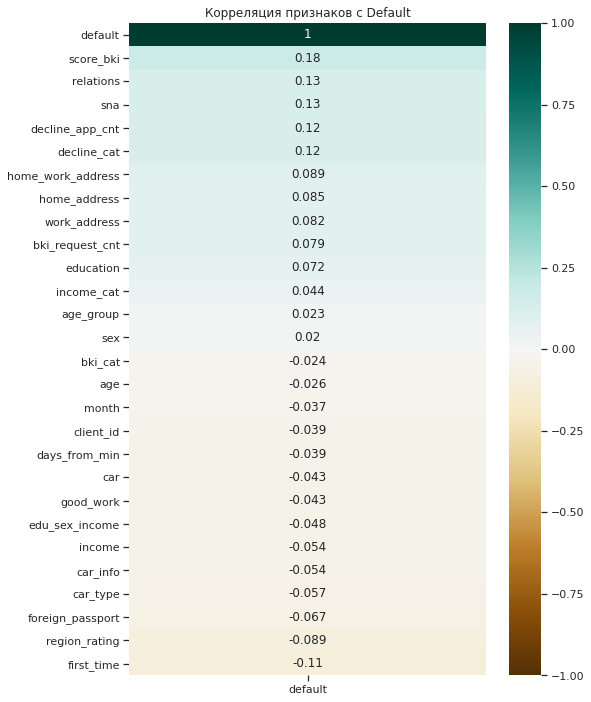

In [113]:
# Посмотрим на корреляцию признаков с целевой переменной Rating, отсортируем
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data[data['sample'] == 1].drop(
    ['sample'], axis=1).corr()[['default']].sort_values(by='default', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Корреляция признаков с Default')

Сформируем список признаков, которые коллинеарны. Для этого выставим критерий наличия корреляции больше 0.8 или -0.8.

In [114]:
# Сформируем сет со скоррелированными признаками
correlated_features = set()

# Удаляем целевую переменную из матрицы коррелиций, тк корреляция с ней, - хорошо для модели
correlation_matrix = data[data['sample'] == 1].drop(
    ['default', 'sample'], axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[j]
            correlated_features.add(colname)

print('Список скоррелированных признаков на удаление из обучения модели:',
      correlated_features)

Список скоррелированных признаков на удаление из обучения модели: {'days_from_min', 'home_address', 'car_type', 'client_id', 'decline_app_cnt', 'car', 'sna', 'first_time', 'work_address'}


#### Снижение размерности признаков с помощью поиска статистически значимых различий тестом Стьюдента

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдент*. Проверим нулевую гипотезу о том, что распределения дефолта по различным параметрам неразличимы.

In [115]:
# Проходим по колонкам, которые исключали из корреляционного анализа
for column in (cat_cols):
    #print("\n\nПроверяется колонка:", column)
    get_stat_dif(column)

Не найдены статистически значимые различия для колонки и комбинации education (1, 0)
Не найдены статистически значимые различия для колонки и комбинации sna (2, 3)
Не найдены статистически значимые различия для колонки и комбинации region_rating (50, 60)
Не найдены статистически значимые различия для колонки и комбинации month (3, 2)
Не найдены статистически значимые различия для колонки и комбинации car_info (0, 1)
Не найдены статистически значимые различия для колонки и комбинации home_work_address (1.0860593687468518, 1.3980957442100508)
Не найдены статистически значимые различия для колонки и комбинации age_group (0, 2)
Не найдены статистически значимые различия для колонки и комбинации income_cat (1, 0)
Не найдены статистически значимые различия для колонки и комбинации decline_cat (2, 3)


In [116]:
# Сформируем сет для статистически незначимых признаков
to_remove_features = set()

to_remove_features.add('hot_education_0')
to_remove_features.add('hot_sna_3')
to_remove_features.add('hot_region_rating_60')
to_remove_features.add('hot_month_2')
to_remove_features.add('hot_car_info_1')
to_remove_features.add('hot_home_work_address_1.3980957442100392')
to_remove_features.add('hot_age_group_2')
to_remove_features.add('hot_income_cat_0')
to_remove_features.add('hot_decline_cat_3')

print('\n Список признаков на пересмотр из обучения модели:', to_remove_features)


 Список признаков на пересмотр из обучения модели: {'hot_education_0', 'hot_month_2', 'hot_sna_3', 'hot_decline_cat_3', 'hot_region_rating_60', 'hot_home_work_address_1.3980957442100392', 'hot_car_info_1', 'hot_age_group_2', 'hot_income_cat_0'}


Объединяем списки колонок на удаление из анализа выше.


In [117]:
# Формируем финальный список колонок на удаление
drop_features = correlated_features.union(to_remove_features)
drop_features = list(drop_features)
print('Список признаков на удаления из обучения модели:', drop_features)

Список признаков на удаления из обучения модели: ['days_from_min', 'hot_education_0', 'home_address', 'hot_month_2', 'hot_sna_3', 'car_type', 'hot_decline_cat_3', 'client_id', 'hot_region_rating_60', 'hot_home_work_address_1.3980957442100392', 'decline_app_cnt', 'car', 'sna', 'first_time', 'hot_car_info_1', 'hot_income_cat_0', 'work_address', 'hot_age_group_2']


#### Построение модели и анализ метрик

In [118]:
# Предобработка данных
df_preproc = preproc_data(data, drop_list=False)
X, y, cols = data_preparing(df_preproc, prep_type='train', cols_update=False)

# Сформируем список колонок, который должен быть у данных после удаления всех колонок
final_cols = []
final_cols = list(set(cols) - set(drop_features))

X, y, cols = data_preparing(df_preproc, prep_type='train', cols_update=True)

# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [119]:
# Создаём модель
model = LogisticRegression(solver='liblinear', random_state=RANDOM_SEED)

# Обучаем, получаем предсказания
y_pred, probs = log_model_use(model, X_train, X_test, y_train, y_test)


МЕТРИКИ МОДЕЛИ 

Основные метрики

                  precision    recall  f1-score   support

non-default (0)       0.88      1.00      0.93     12933
    default (1)       0.42      0.02      0.05      1827

       accuracy                           0.88     14760
      macro avg       0.65      0.51      0.49     14760
   weighted avg       0.82      0.88      0.82     14760



ROC-кривая



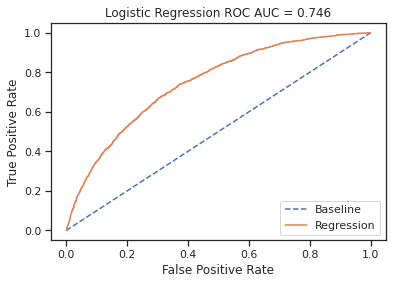



Матрица ошибок



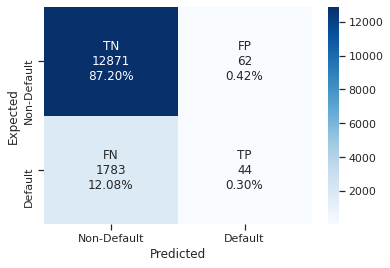

In [120]:
# Строим метрики по моделе
roc_auc, accuracy, precision, recall, f1, f1_def = model_metrics(
    y_test, y_pred, probs)

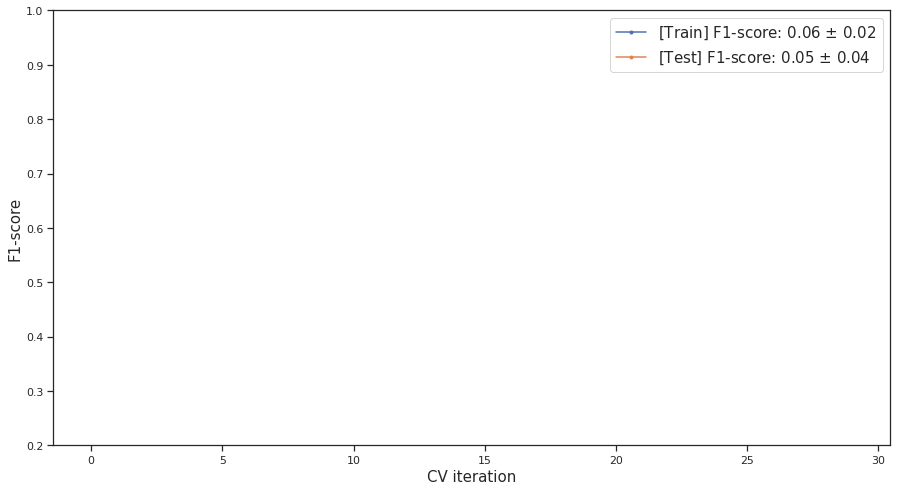

In [121]:
# Делаем кросс-валидацию
cross_validation(model, X_train, X_test, y_train, y_test)

In [122]:
# Добавляем данные эксперимента в итоговый отчет
ml_report = generate_report(ml_report, roc_auc, accuracy, precision,
                            recall, f1, f1_def, 'LogisticRegression_FeatureSelection_Corr')
ml_report

,ROC-AUC,F1-Score,F1-Score Default,Precision,Recall,Accuracy
LogisticRegression_Naive,0.743,0.487,0.040,0.621,0.508,0.874
LogisticRegression_Feature_Engineering,0.743,0.487,0.040,0.621,0.508,0.874
LogisticRegression_FeatureSelection_Corr,0.746,0.489,0.046,0.647,0.510,0.875


Вывод: качество модели особо не улучшилось, всё равно есть переобучение модели. Но уменьшили размерность признаков (59, вместо 71).

#### 5.2.2 RFE Feature Selection

##### Сформируем список признаков с помощью RFE

In [123]:
# Предобработка данных
df_preproc = preproc_data(data, drop_list=False)  # без учета корреляции
X, y, cols = data_preparing(df_preproc, prep_type='train', cols_update=False)

# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [124]:
# Используем RFE для отбора признаков
rfe = RFE(model, n_features_to_select=None)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
print(rfe.estimator_)

[ True False  True False False  True  True  True False  True False False
 False  True  True  True  True False  True  True False False False False
 False  True False  True  True  True False False False  True  True  True
 False False False  True False False False False False False False  True
  True  True  True False False  True  True False False False  True  True
  True  True False  True False  True  True  True  True False False]
[ 1 27  1 12 32  1  1  1 21  1 22 37 18  1  1  1  1 26  1  1  5 28  9 17
  8  1 15  1  1  1 34 33 14  1  1  1 23 24 25  1 20  6 31 19  3  2  4  1
  1  1  1 30 11  1  1 16 35  7  1  1  1  1 36  1 13  1  1  1  1 29 10]
LogisticRegression(random_state=42, solver='liblinear')


In [125]:
# Создадим список индексов колонок, у которых ранг равен 1, - rfe_indices
rfe_cols = []
rfe_indices = []
final_cols = []

rfe_cols = rfe.ranking_
rfe_indices = [index for index, element in enumerate(rfe_cols) if element == 1]

# Запишем в писок final_cols отобранные признаки
for index in rfe_indices:
    final_cols.append(cols[index])

##### Обучим модель, проанализируем метрики

In [126]:
# Предобработка данных
df_preproc = preproc_data(data, drop_list=False)  # без учета корреляции
# данные с колонками final_cols
X, y, cols = data_preparing(df_preproc, prep_type='train', cols_update=True)

# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [127]:
# Создаём модель
model = LogisticRegression(solver='liblinear', random_state=RANDOM_SEED)

# Обучаем, получаем предсказания
y_pred, probs = log_model_use(model, X_train, X_test, y_train, y_test)


МЕТРИКИ МОДЕЛИ 

Основные метрики

                  precision    recall  f1-score   support

non-default (0)       0.88      1.00      0.93     12933
    default (1)       0.45      0.03      0.05      1827

       accuracy                           0.88     14760
      macro avg       0.66      0.51      0.49     14760
   weighted avg       0.83      0.88      0.82     14760



ROC-кривая



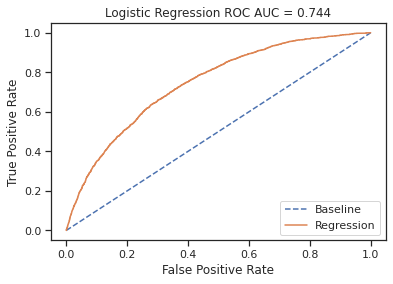



Матрица ошибок



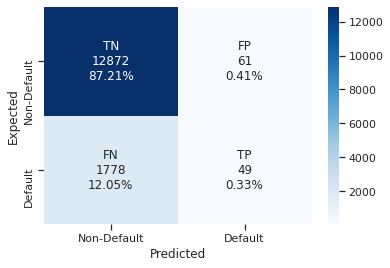

In [128]:
# Строим метрики по моделе
roc_auc, accuracy, precision, recall, f1, f1_def = model_metrics(
    y_test, y_pred, probs)

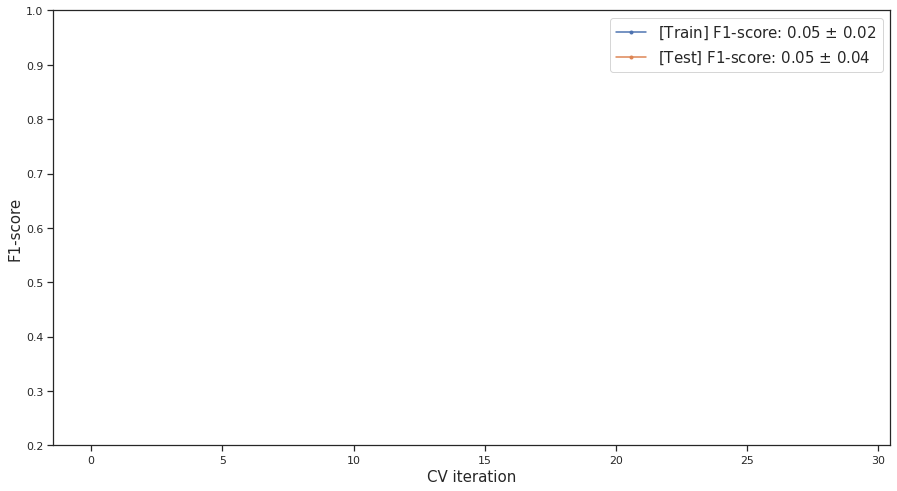

In [129]:
# Делаем кросс-валидацию
cross_validation(model, X_train, X_test, y_train, y_test)

In [130]:
# Добавляем данные эксперимента в итоговый отчет
ml_report = generate_report(ml_report, roc_auc, accuracy, precision,
                            recall, f1, f1_def, 'LogisticRegression_FeatureSelection_RFE')
ml_report

,ROC-AUC,F1-Score,F1-Score Default,Precision,Recall,Accuracy
LogisticRegression_Naive,0.743,0.487,0.040,0.621,0.508,0.874
LogisticRegression_Feature_Engineering,0.743,0.487,0.040,0.621,0.508,0.874
LogisticRegression_FeatureSelection_Corr,0.746,0.489,0.046,0.647,0.510,0.875
LogisticRegression_FeatureSelection_RFE,0.744,0.492,0.051,0.662,0.511,0.875


Вывод: 
- модель показывает более хороший показатель F-1 Score для '1', но хуже по ROC-AUC. Размерность признаков - 35
- кросс-валидация показывает, что модель не переобучена.

### 5.3 Model OVER- UNDER-Sampling

Попробуем поработать с несбалансированностью выборки.

##### Сравним различные методики семплирования и эффективность моделей

МЕТОД: SMOTE
Количество дефолтных клиентов в новом датасете: 64427
Количество недефолтных клиентов в новом датасете: 64427

Доля дефолтных клиентов в новом датасете: 0.5
Доля недефолтных клиентов в новом датасете: 0.5


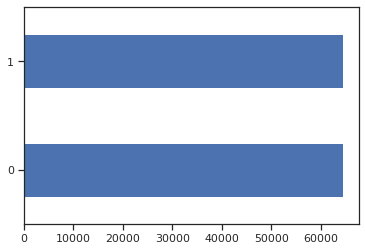


МЕТРИКИ МОДЕЛИ 

Основные метрики

                  precision    recall  f1-score   support

non-default (0)       0.69      0.68      0.68     12877
    default (1)       0.68      0.70      0.69     12894

       accuracy                           0.69     25771
      macro avg       0.69      0.69      0.69     25771
   weighted avg       0.69      0.69      0.69     25771



ROC-кривая



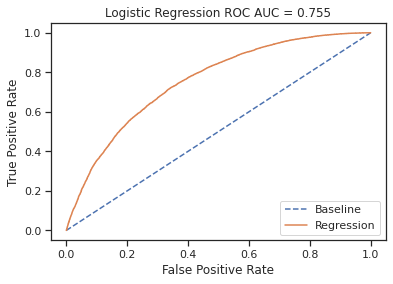



Матрица ошибок



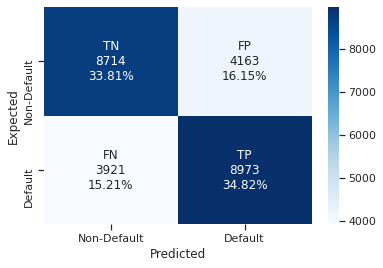

Делаем кросс-валидацию.


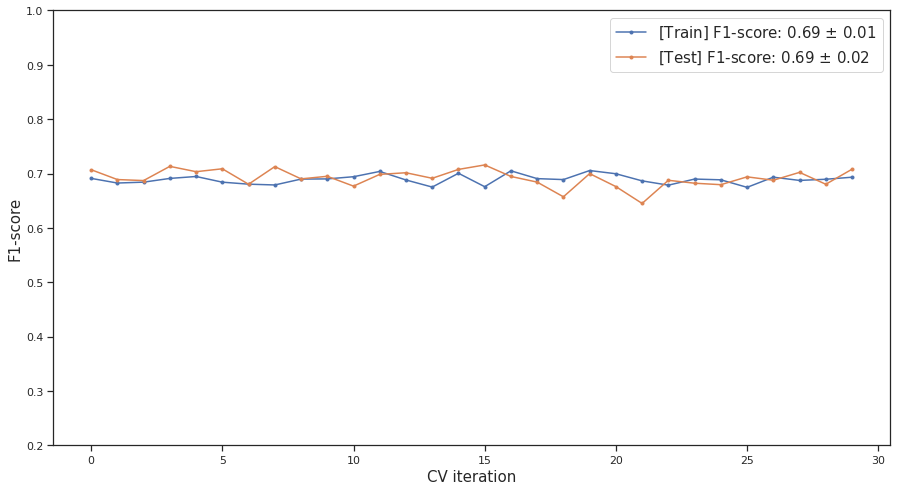

МЕТОД: ADASYN
Количество дефолтных клиентов в новом датасете: 63459
Количество недефолтных клиентов в новом датасете: 64427

Доля дефолтных клиентов в новом датасете: 0.4962153793222088
Доля недефолтных клиентов в новом датасете: 0.5037846206777912


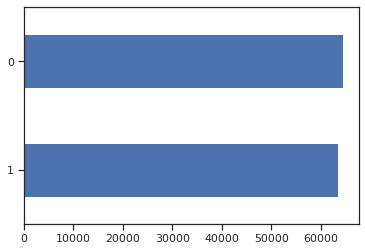


МЕТРИКИ МОДЕЛИ 

Основные метрики

                  precision    recall  f1-score   support

non-default (0)       0.69      0.67      0.68     13052
    default (1)       0.67      0.69      0.68     12526

       accuracy                           0.68     25578
      macro avg       0.68      0.68      0.68     25578
   weighted avg       0.68      0.68      0.68     25578



ROC-кривая



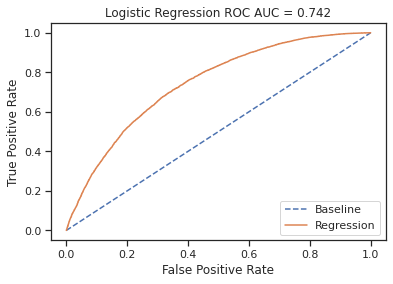



Матрица ошибок



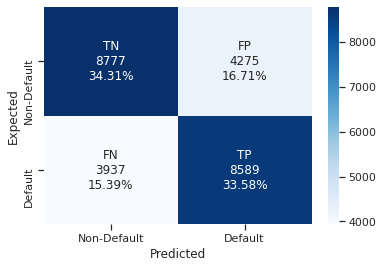

Делаем кросс-валидацию.


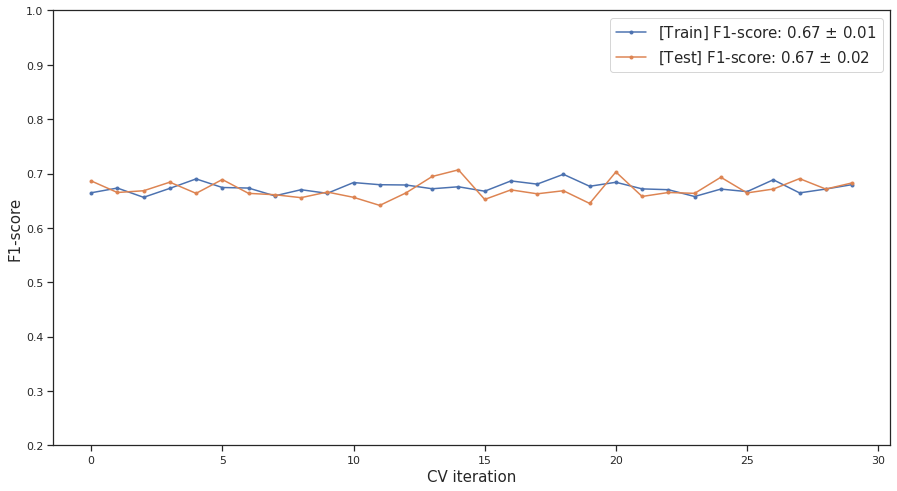

МЕТОД: RandomOverSampler
Количество дефолтных клиентов в новом датасете: 64427
Количество недефолтных клиентов в новом датасете: 64427

Доля дефолтных клиентов в новом датасете: 0.5
Доля недефолтных клиентов в новом датасете: 0.5


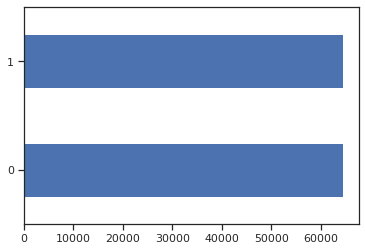


МЕТРИКИ МОДЕЛИ 

Основные метрики

                  precision    recall  f1-score   support

non-default (0)       0.68      0.67      0.67     12877
    default (1)       0.68      0.68      0.68     12894

       accuracy                           0.68     25771
      macro avg       0.68      0.68      0.68     25771
   weighted avg       0.68      0.68      0.68     25771



ROC-кривая



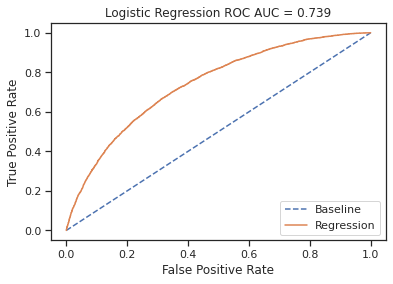



Матрица ошибок



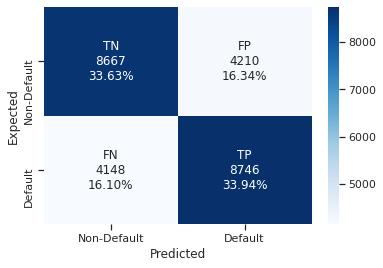

Делаем кросс-валидацию.


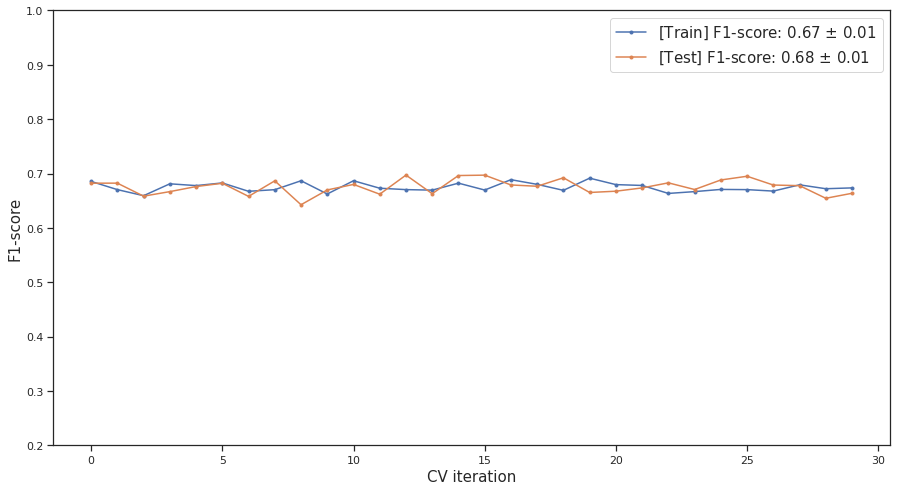

МЕТОД: RandomUnderSampler
Количество дефолтных клиентов в новом датасете: 9372
Количество недефолтных клиентов в новом датасете: 9372

Доля дефолтных клиентов в новом датасете: 0.5
Доля недефолтных клиентов в новом датасете: 0.5


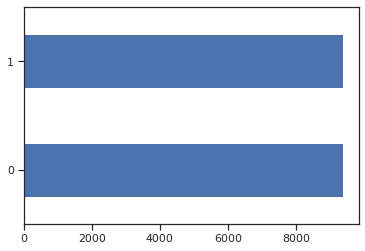


МЕТРИКИ МОДЕЛИ 

Основные метрики

                  precision    recall  f1-score   support

non-default (0)       0.69      0.67      0.68      1887
    default (1)       0.67      0.69      0.68      1862

       accuracy                           0.68      3749
      macro avg       0.68      0.68      0.68      3749
   weighted avg       0.68      0.68      0.68      3749



ROC-кривая



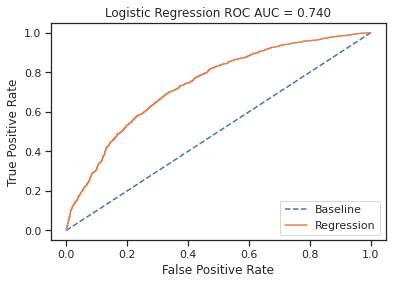



Матрица ошибок



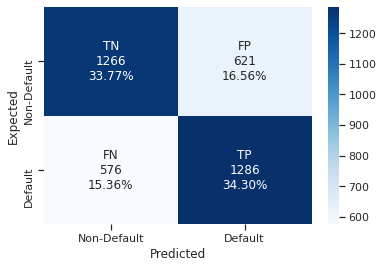

Делаем кросс-валидацию.


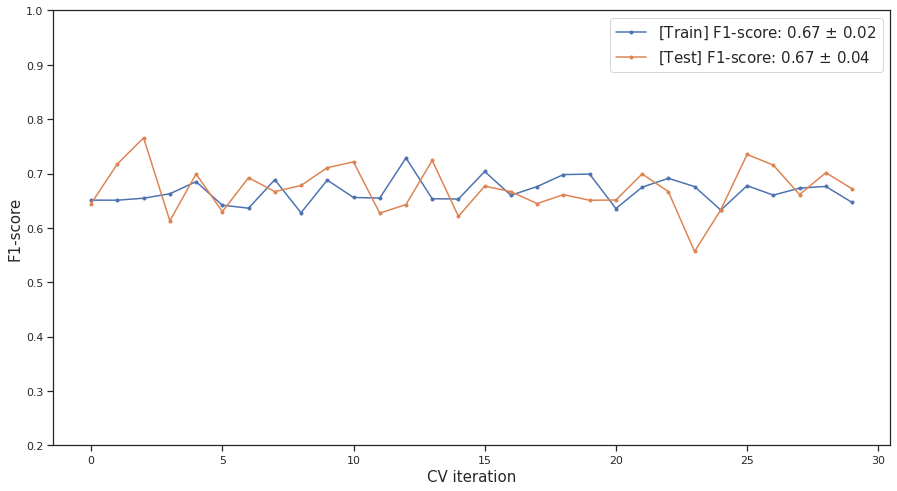

,ROC-AUC,F1-Score,F1-Score Default,Precision,Recall,Accuracy
LogisticRegression_Naive,0.743,0.487,0.040,0.621,0.508,0.874
LogisticRegression_Feature_Engineering,0.743,0.487,0.040,0.621,0.508,0.874
LogisticRegression_FeatureSelection_Corr,0.746,0.489,0.046,0.647,0.510,0.875
LogisticRegression_FeatureSelection_RFE,0.744,0.492,0.051,0.662,0.511,0.875
LogisticRegression_SMOTE,0.755,0.686,0.689,0.686,0.686,0.686
LogisticRegression_ADASYN,0.742,0.679,0.677,0.679,0.679,0.679
LogisticRegression_RandomOverSampler,0.739,0.676,0.677,0.676,0.676,0.676
LogisticRegression_RandomUnderSampler,0.740,0.681,0.682,0.681,0.681,0.681


In [131]:
# Создадим список со всеми вариантами over/under sampling
flag_list = ['SMOTE', 'ADASYN', 'RandomOverSampler', 'RandomUnderSampler']

for flag in flag_list:
    print("МЕТОД:", flag)

    # Предобработка данных
    df_preproc = preproc_data(data, drop_list = True) #c учетом корреляции
    X, y, cols = data_preparing(df_preproc, prep_type = 'train', cols_update = False)
    X, y = resemble_result(X, y, flag = flag, report = True)

    # Выделим 20% данных на валидацию (параметр test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

    # Создаём модель 
    model = LogisticRegression(solver='liblinear')

    # Обучаем, получаем предсказания
    y_pred, probs = log_model_use(model, X_train, X_test, y_train, y_test)
    
    # Строим метрики по моделе
    roc_auc, accuracy, precision, recall, f1, f1_def = model_metrics(y_test, y_pred, probs)
    
    # Делаем кросс-валидацию
    print("Делаем кросс-валидацию.")
    cross_validation(model, X_train, X_test, y_train, y_test)
    
    # Добавляем данные эксперимента в итоговый отчет
    ml_report = generate_report(ml_report, roc_auc, accuracy, precision, recall, f1, f1_def, f'LogisticRegression_{flag}')
    
    print('='*130)

ml_report

Вывод:
1. Лучшие результаты показывает SMOTE метод, будем его использовать для дальнейших экспериментов
2. Семплирование улучшает F-1 Score для предсказания дефолтных заемщиков почти в 10! раз. 

<a id="5.4"></a>

### 5.4 Model Hyperparameters Tuning

Гиперпараметры — это внешние параметры для классификатора, которые не могут быть изучены самим классификатором и чаще всего задаются вручную. Логистическая регрессия, например, не способна сама выучить наилучшее значение для, например, параметра С.  В scikit-learn они передаются в качестве аргументов конструктору класса. Найдя оптимальные параметры, можем улучшить предсказательную силу логистической регрессии.

Попробуем найти оптимальное значение параметра регуляризации для логистической регрессии. В scikit-learn есть два общих подхода к поиску: с помощью GridSearchCV и RandomizedSearchCV. 

##### Поиск гиперпараметров GridSearchCV 

In [132]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

# Предобработка данных
df_preproc = preproc_data(data, drop_list = True) #c учетом корреляции
X, y, cols = data_preparing(df_preproc, prep_type = 'train', cols_update = False)
X, y = resemble_result(X, y, flag = "SMOTE",report = False)
# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# Создаём модель 
model = LogisticRegression(solver='liblinear', random_state=RANDOM_SEED)
# Обучаем, получаем предсказания
y_pred, probs = log_model_use(model, X_train, X_test, y_train, y_test)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, scoring='f1', verbose=0)

best_model = clf.fit(X_train, y_train)

model = clf.best_estimator_

# Посмотрим лучшие параметры
print('Лучшие параметры модели:\n')
print('\tЛучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('\tЛучшее C:', best_model.best_estimator_.get_params()['C'])

# Печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1-Score: %.4f' % f1_score(y_test, preds))
print('ROC-AUC: %.4f' % roc_auc_score(y_test, probs))

Лучшие параметры модели:

	Лучшее Penalty: l2
	Лучшее C: 3593.813663804626
Accuracy: 0.6865
Precision: 0.6833
Recall: 0.6960
F1-Score: 0.6896
ROC-AUC: 0.7546


In [133]:
# Запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3, чтобы получить оптимальные параметры модели в первом приближении

# Предобработка данных
df_preproc = preproc_data(data, drop_list = True) #c учетом корреляции
X, y, cols = data_preparing(df_preproc, prep_type = 'train', cols_update = False)
X, y = resemble_result(X, y, flag = "SMOTE",report = False)
# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# Создаём модель 
model = LogisticRegression(solver='liblinear', random_state=RANDOM_SEED)
# Обучаем, получаем предсказания
y_pred, probs = log_model_use(model, X_train, X_test, y_train, y_test)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

# Печатаем параметры
best_parameters = model.get_params()
print('Лучшие параметры модели:\n')
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

# Печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1-Score: %.4f' % f1_score(y_test, preds))
print('ROC-AUC: %.4f' % roc_auc_score(y_test, probs))

Лучшие параметры модели:

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6866
Precision: 0.6833
Recall: 0.6963
F1-Score: 0.6897
ROC-AUC: 0.7546


##### Подставим оптимальные гиперпараметны в модель, проанализируем результаты экспериментов


МЕТРИКИ МОДЕЛИ 

Основные метрики

                  precision    recall  f1-score   support

non-default (0)       0.69      0.68      0.68     12877
    default (1)       0.68      0.70      0.69     12894

       accuracy                           0.69     25771
      macro avg       0.69      0.69      0.69     25771
   weighted avg       0.69      0.69      0.69     25771



ROC-кривая



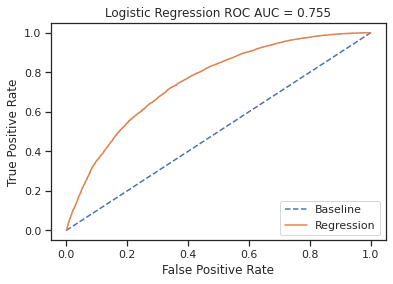



Матрица ошибок



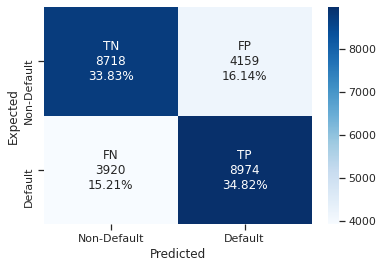

Делаем кросс-валидацию.


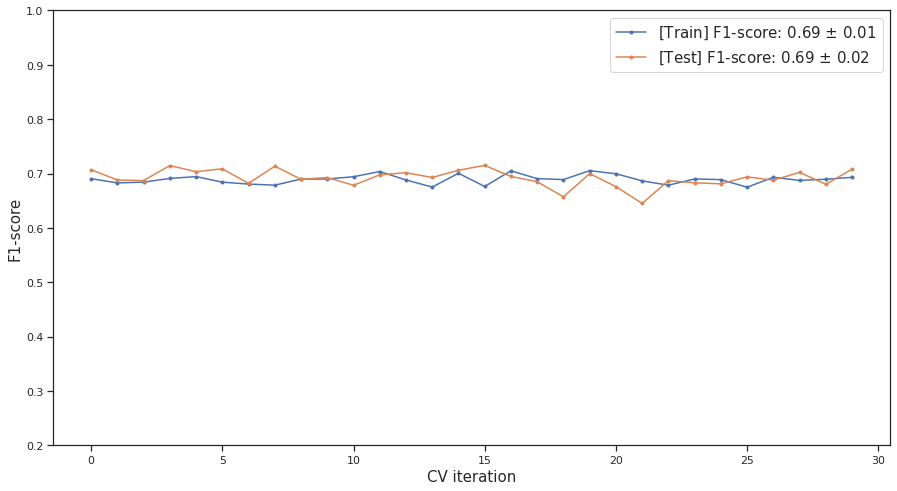

In [134]:
# Модель с использованием простого списоба поиска параметров модели

# Предобработка данных
df_preproc = preproc_data(data, drop_list=True)  # c учетом корреляции
X, y, cols = data_preparing(df_preproc, prep_type='train', cols_update=False)
X, y = resemble_result(X, y, flag="SMOTE", report=False)

# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём модель
model = LogisticRegression(random_state=RANDOM_SEED,
                           C=464,
                           penalty='l2',
                           solver='liblinear')

# Обучаем, получаем предсказания
y_pred, probs = log_model_use(model, X_train, X_test, y_train, y_test)

# Строим метрики по моделе
roc_auc, accuracy, precision, recall, f1, f1_def = model_metrics(
    y_test, y_pred, probs)

# Делаем кросс-валидацию
print("Делаем кросс-валидацию.")
cross_validation(model, X_train, X_test, y_train, y_test)

# Добавляем данные эксперимента в итоговый отчет
ml_report = generate_report(ml_report, roc_auc, accuracy, precision,
                            recall, f1, f1_def, 'LogisticRegression_GridSearchCV_simple')


МЕТРИКИ МОДЕЛИ 

Основные метрики

                  precision    recall  f1-score   support

non-default (0)       0.69      0.68      0.68     12877
    default (1)       0.68      0.70      0.69     12894

       accuracy                           0.69     25771
      macro avg       0.69      0.69      0.69     25771
   weighted avg       0.69      0.69      0.69     25771



ROC-кривая



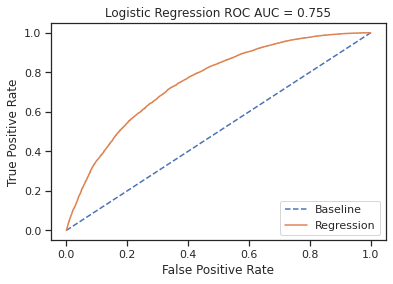



Матрица ошибок



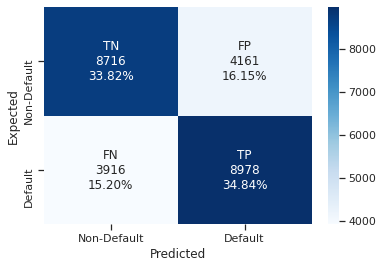

Делаем кросс-валидацию.


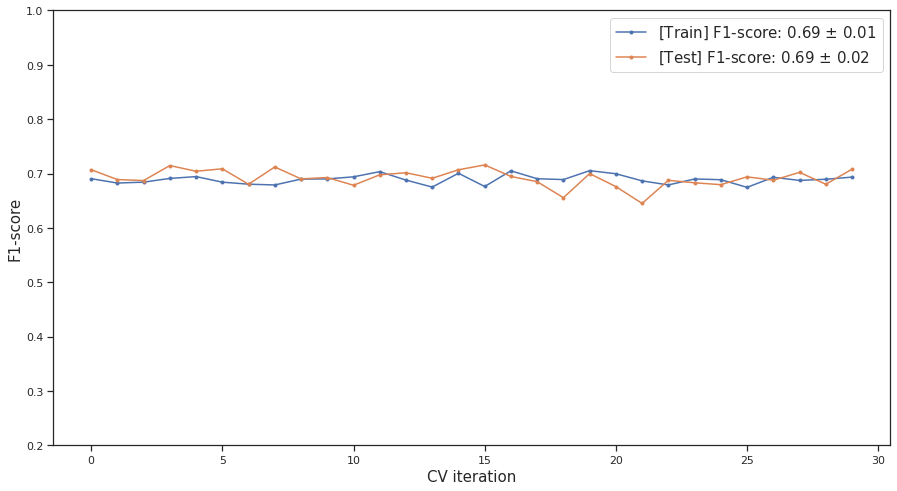

In [135]:
# Модель с использованием расширенного спсоба поиска параметров модели
# Предобработка данных
df_preproc = preproc_data(data, drop_list=True)  # c учетом корреляции
X, y, cols = data_preparing(df_preproc, prep_type='train', cols_update=False)
X, y = resemble_result(X, y, flag="SMOTE", report=False)

# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём модель
model = LogisticRegression(random_state=RANDOM_SEED,
                           C=1,
                           class_weight='balanced',
                           dual=False,
                           fit_intercept=True,
                           intercept_scaling=1,
                           l1_ratio=None,
                           multi_class='auto',
                           n_jobs=None,
                           penalty='none',
                           solver='newton-cg',
                           tol=0.001,
                           verbose=0,
                           warm_start=False)

# Обучаем, получаем предсказания
y_pred, probs = log_model_use(model, X_train, X_test, y_train, y_test)

# Строим метрики по моделе
roc_auc, accuracy, precision, recall, f1, f1_def = model_metrics(
    y_test, y_pred, probs)

# Делаем кросс-валидацию
print("Делаем кросс-валидацию.")
cross_validation(model, X_train, X_test, y_train, y_test)

# Добавляем данные эксперимента в итоговый отчет
ml_report = generate_report(ml_report, roc_auc, accuracy, precision,
                            recall, f1, f1_def, 'LogisticRegression_GridSearchCV_complex')

##### Поиск гиперпараметров train_test_split

Поэкспериментируем с параметрами:
* stratify - целевая переменная
* shuffle - True/False


МЕТРИКИ МОДЕЛИ 

Основные метрики

                  precision    recall  f1-score   support

non-default (0)       0.69      0.67      0.68     12886
    default (1)       0.68      0.69      0.69     12885

       accuracy                           0.68     25771
      macro avg       0.68      0.68      0.68     25771
   weighted avg       0.68      0.68      0.68     25771



ROC-кривая



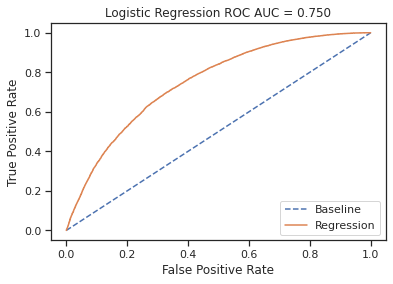



Матрица ошибок



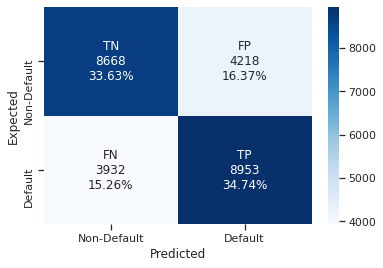

Делаем кросс-валидацию.


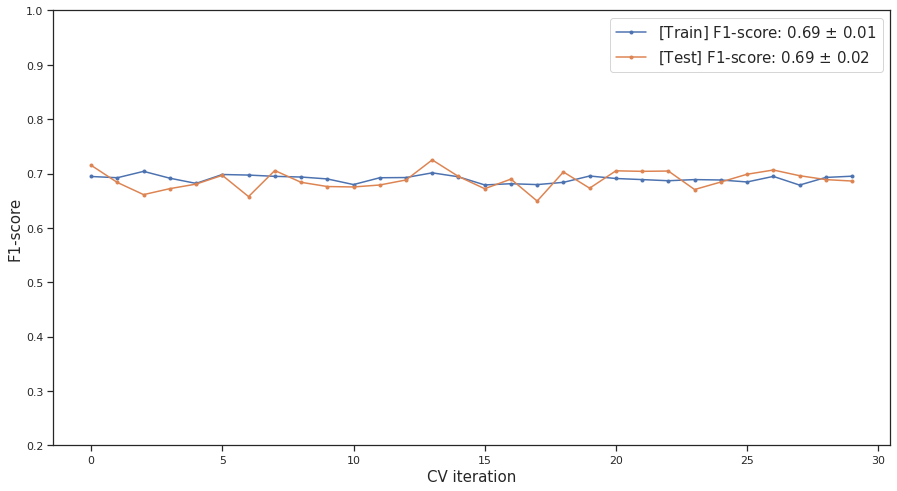

In [136]:
# Модель с использованием train_test_split, stratify=True

# Предобработка данных
df_preproc = preproc_data(data, drop_list=True)  # c учетом корреляции
X, y, cols = data_preparing(df_preproc, prep_type='train', cols_update=False)
X, y = resemble_result(X, y, flag="SMOTE", report=False)

# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

# Создаём модель
model = LogisticRegression(random_state=RANDOM_SEED,
                           C=1,
                           class_weight='balanced',
                           dual=False,
                           fit_intercept=True,
                           intercept_scaling=1,
                           l1_ratio=None,
                           multi_class='auto',
                           n_jobs=None,
                           penalty='none',
                           solver='newton-cg',
                           tol=0.001,
                           verbose=0,
                           warm_start=False)

# Обучаем, получаем предсказания
y_pred, probs = log_model_use(model, X_train, X_test, y_train, y_test)

# Строим метрики по моделе
roc_auc, accuracy, precision, recall, f1, f1_def = model_metrics(
    y_test, y_pred, probs)

# Делаем кросс-валидацию
print("Делаем кросс-валидацию.")
cross_validation(model, X_train, X_test, y_train, y_test)

# Добавляем данные эксперимента в итоговый отчет
ml_report = generate_report(ml_report, roc_auc, accuracy, precision,
                            recall, f1, f1_def, 'LogisticRegression_TrainSplitStratisfyOn')


МЕТРИКИ МОДЕЛИ 

Основные метрики

                  precision    recall  f1-score   support

non-default (0)       0.93      0.67      0.78     12873
    default (1)       0.22      0.64      0.33      1887

       accuracy                           0.67     14760
      macro avg       0.58      0.66      0.56     14760
   weighted avg       0.84      0.67      0.72     14760



ROC-кривая



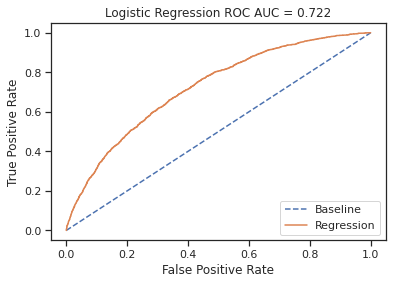



Матрица ошибок



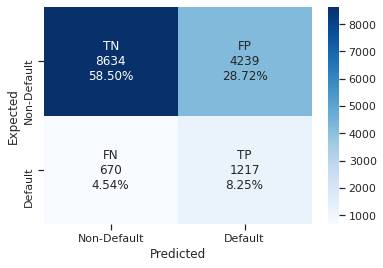

Делаем кросс-валидацию.


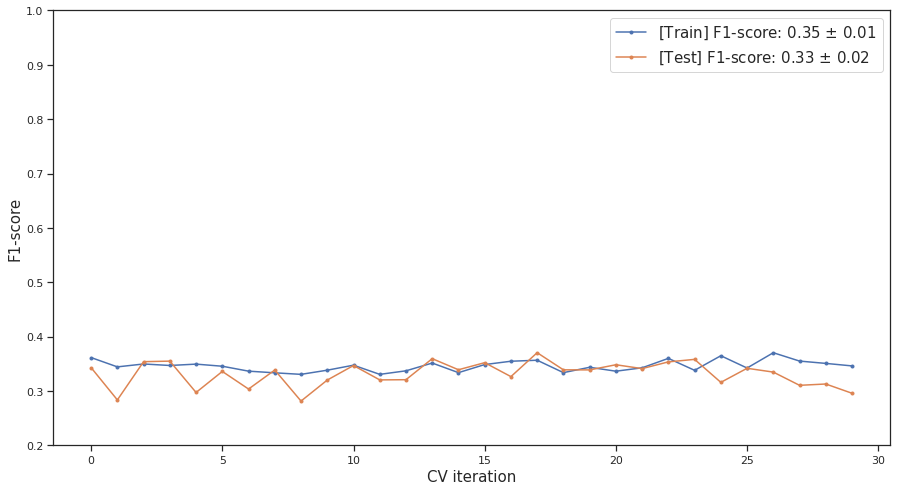

In [137]:
# Модель с использованием train_test_split, shuffle=False

# Предобработка данных
df_preproc = preproc_data(data, drop_list=True)  # c учетом корреляции
X, y, cols = data_preparing(df_preproc, prep_type='train', cols_update=False)
#X, y = resemble_result(X, y, flag = "SMOTE",report = False)

# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=False)

# Создаём модель
model = LogisticRegression(random_state=RANDOM_SEED,
                           C=1,
                           class_weight='balanced',
                           dual=False,
                           fit_intercept=True,
                           intercept_scaling=1,
                           l1_ratio=None,
                           multi_class='auto',
                           n_jobs=None,
                           penalty='none',
                           solver='newton-cg',
                           tol=0.001,
                           verbose=0,
                           warm_start=False)

# Обучаем, получаем предсказания
y_pred, probs = log_model_use(model, X_train, X_test, y_train, y_test)

# Строим метрики по моделе
roc_auc, accuracy, precision, recall, f1, f1_def = model_metrics(
    y_test, y_pred, probs)

# Делаем кросс-валидацию
print("Делаем кросс-валидацию.")
cross_validation(model, X_train, X_test, y_train, y_test)

# Добавляем данные эксперимента в итоговый отчет
ml_report = generate_report(ml_report, roc_auc, accuracy, precision,
                            recall, f1, f1_def, 'LogisticRegression_TrainSplitShuffleOff')

<a id="5.5."></a>
## 5.5. Experiments Summary

Посмотрим на отчет основных метрик экспериментов.

In [138]:
# Выгрузим датафрейм
ml_report

,ROC-AUC,F1-Score,F1-Score Default,Precision,Recall,Accuracy
LogisticRegression_Naive,0.743,0.487,0.040,0.621,0.508,0.874
LogisticRegression_Feature_Engineering,0.743,0.487,0.040,0.621,0.508,0.874
LogisticRegression_FeatureSelection_Corr,0.746,0.489,0.046,0.647,0.510,0.875
LogisticRegression_FeatureSelection_RFE,0.744,0.492,0.051,0.662,0.511,0.875
LogisticRegression_SMOTE,0.755,0.686,0.689,0.686,0.686,0.686
LogisticRegression_ADASYN,0.742,0.679,0.677,0.679,0.679,0.679
LogisticRegression_RandomOverSampler,0.739,0.676,0.677,0.676,0.676,0.676
LogisticRegression_RandomUnderSampler,0.740,0.681,0.682,0.681,0.681,0.681
LogisticRegression_GridSearchCV_simple,0.755,0.686,0.690,0.687,0.687,0.687
LogisticRegression_GridSearchCV_complex,0.755,0.687,0.690,0.687,0.687,0.687


Text(0.5, 1.0, 'Изменение ROC-AUC и F-1 Score Default между экспериментами')

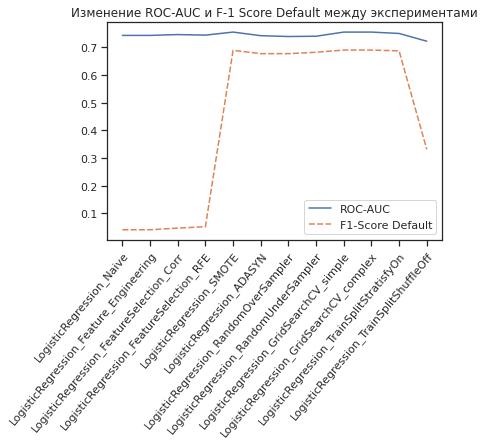

In [139]:
# Построим график
fig, ax = plt.subplots()
experiment = ml_report.index.values.tolist()

sns.lineplot(data=ml_report[['ROC-AUC', 'F1-Score Default']])


# We want to show all ticks...
ax.set_xticks(np.arange(len(experiment)))
# ... and label them with the respective list entries
ax.set_xticklabels(experiment)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=50, ha="right",
         rotation_mode="anchor")

plt.title('Изменение ROC-AUC и F-1 Score Default между экспериментами')

<a id="6"></a>

# 6. SUBMISSION 
Готовим Submission на Kaggle.

Путем экспериментов было выявлено, что для test данных для более высокого рейстинга на борде соревнований подходит:
* RandomUnderSampler опция
* train_test_split с shuffle = False.

Соревнования сравнивают ROC-AUC значение, но по ходу экспериментов заметили, что важно и F1-Score. Более высокие рейтинги были получены при сабмите данных, где минимальное число предсказанных дефолтных клиентов.

In [140]:
# Предобработка данных. Отсев признаков на базе коррелляционного анализа
df_preproc = preproc_data(data, drop_list=True)
X, y, cols = data_preparing(df_preproc, prep_type='train', cols_update=False)
# Используем RandomUnderSampler оверсемплирование
X, y = resemble_result(X, y, flag="RandomUnderSampler", report=False)

# Создаём модель
model = LogisticRegression(random_state=RANDOM_SEED,
                           C=1,
                           class_weight='balanced',
                           dual=False,
                           fit_intercept=True,
                           intercept_scaling=1,
                           l1_ratio=None,
                           multi_class='auto',
                           n_jobs=None,
                           penalty='none',
                           solver='newton-cg',
                           tol=0.001,
                           verbose=0,
                           warm_start=False)
"""
# Закоментированы альтернативные настройки модели
model = LogisticRegression(random_state=RANDOM_SEED,
                           C=1,
                           penalty='l2',
                           solver='liblinear')
"""

# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=False)
y_pred, probs = log_model_use(model, X_train, X_test, y_train, y_test)

In [141]:
# Предобработка данных для test набора
X_test, y_test, cols = data_preparing(
    df_preproc, prep_type='test', cols_update=False)
X_test.shape, y_test.shape

((36349, 53), (36349, 1))

In [142]:
# Предсказание дефолта
y_pred = model.predict(X_test)

<AxesSubplot:ylabel='0'>

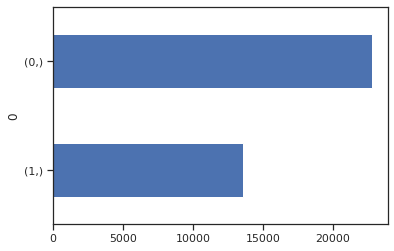

In [143]:
# Посмотрим на распределине финальных предсказаний
df_y_pred = pd.DataFrame(y_pred)
df_y_pred.value_counts(ascending=True).plot(kind='barh')

In [144]:
# Рассчитаем вероятности
predict_submission = model.predict_proba(X_test)
probs = predict_submission[:, 1]

In [145]:
# Сформируем submission.csv
df_test['default'] = predict_submission[:, 1]
submission = df_test[['client_id', 'default']]
submission.to_csv('submission.csv', index=False)
display(submission.shape)
submission.head(5)

(36349, 2)

,client_id,default
0,74835,0.200090
1,17527,0.665745
2,75683,0.333804
3,26883,0.426943
4,28862,0.136166


<a id="7"></a>

# 7. SUMMARY 

1.Исходные данные чистые, количество пропусков менее, чем 1% у одного признака (education).

2.Анализ данных:
* Зависимости с целевой переменной:
    * Дефолтные клиенты в среднем чуть младше
    * Дефолтные клиенты в среднем имеют большее количество отмененных заявок
    * Дефолтные клиенты в среднем имеют больше запросов в БКИ
    * Дефолтные клиенты в среднем имеют более низкий доход
    * Дефолтные клиенты в среднем имеют более высокий скоринговый балл по данным из БКИ
    * Большее количество дефолтных клиентов в начале отчетного периода в данных
    * Нет значительной зависимости дефолтных клиентов от пола
    * Дефолтные клиенты в среднем не имеют машины, заграничного паспорта и хорошей работы. В случае наличия машины, дефолтные клиенты чаще те, у кого отечественный автомобиль, а не иномарка
    * Дефолтные клиенты чаще живут в областях категории 2, а работают в областях категории 3
    * Дефолтные клиенты чаще встречаются у людей со школьным (SCH) образованием, но и заемщиков с таким образованием больше всего. 
* Корреляция по Пирсону:
    * числовых признаков слабая 
    * категориальных сильная у car/car_type (0.7), home_address / work_address (0.73)
* Наиболее значимая числовая переменная – score_bki. Наиболее значимая категориальная и бинарная переменная – sna.
* Основные числовые признаки имеют тяжёлый правый хвост. Cтратегия работы с выбросами – логарифмирование. Данные не удаляли.
* Целевая переменная несбалансированная, дефолтных клиентов – 12.6% от всех заемщиков.


3.Машинное обучение логистической регрессии:
* Наивная модель неэффективная, несмотря на высокий ROC-AUC (0.746), F-1 для дефолтных значений всего 0.048. По матрице ошибок 97% дефолтных заёмщиков определяются как благонадежные. 
* Результат экспериментов: 
	* Добавление признаков улучшает ROC-AUC, но переобучает модель
	* Уменьшение размерности признаков незначительно улучшает степень переобучения модели и F-1 Score для «1».
	* Over/under-sampling улучшает показать F-1 Score для «1» почти в 10 раз. Из разных вариантов семплирования лучше всего себя показал SMOTE метод.
	* Подобранные параметры GridSearchCV улучшают метрики.

* Лучшие метрики на train:
    * ROC-AUC: 0.755
    * F1-Score: 0.686
    * F1-Score for Default (1): 0.69
    * По матрице ошибок 97% дефолтных заёмщиков определяются как благонадежные, ошибочное определение хороших клиентов, как дефолтных - в % случаев.
* Лучшие метрики на test для Kaggle submission:
    * ROC-AUC: 0.73630.

4.Новые признаки, созданные методом PCA и категоризацией числовых переменных:
* car_info со значениями 0 - машины нет, 1 - машина отечественная, 2 - машина иномарка
* home_work_address – объединение двух признаков с помощью метода главных компонент
* relations –  объединение двух признаков sna, first_time с помощью метода главных компонент
* edu_sex_income – объединение трех связанных признаков с помощью метода главных компонент
* age_group – категории возраста ('toddler','child','adult_young','adult_old', 'elderly')
* income_cat – категоризация дохода по перцентилям ('low','med','high','extra_high)
* bki_cat – категоризация bki_request по перцентилям  ('low','med','high','extra_high')
* decline_cat – 0 – нет отказов, 1 – 1 отказ, 2 – 2 отказа, 3 – 3 отказа, 4 – 4 и более отказов.

5.Оптимизация модели и эксперименты:
1. Учёт различных метрик в оценке модели: не только ROC-AUC, но и F-1 Score, анализ матрица ошибок
2. Создание новых фичей, обработка выбросов, логарифмирование
3. Сокращение количества признаков для обучения (корреляционный анализ, тест стьюдента, sklern RFE)
4. Решение проблемы несбалансированности данных по целевой переменной over/under-sampling различными методами
5. Подбор гиперпараметров модели GridSearchCV.